### TODO for current general pipeline notebook
- 2D plot is not PCA when number of classes is 2
- overlay shapelets with mean class is not visible
- train with AdamW should be possible
- make all trained models accessible after sweep. Currently only best model is kept
- visualization of best match and distance profile is buggy because of rescaling and maybe softmin.
- run with multiple values of max iter
- test with learninshapelet scaling=True
- put hyperparameters into a proper config as dataclass

In [38]:
# CELL 0 — Imports + global config

import os, time, random, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path


import warnings

warnings.filterwarnings("ignore")

# Must be set BEFORE importing keras
os.environ["KERAS_BACKEND"] = "torch"

import keras

# keras.config.set_floatx("float32")

from keras.optimizers import Adam, AdamW
from keras.src.backend.torch.core import device_scope

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA

from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

import torch

In [2]:
# CELL 1 — Repro + small utilities


def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def ensure_dir(p):
    p = pathlib.Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p


def cohen_d(x, y, eps=1e-12):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    sp = math.sqrt(((nx - 1) * vx + (ny - 1) * vy) / max(1, (nx + ny - 2)) + eps)
    return (x.mean() - y.mean()) / sp


def standardize_ucr_name(name: str):
    aliases = {
        "Gunpoint": "GunPoint",
        "gunpoint": "GunPoint",
        "TRACE": "Trace",
        "trace": "Trace",
        "ItalyPowerDemand": "ItalyPowerDemand",
    }
    return aliases.get(name, name)

In [3]:
# CELL 1b — Notebook-level configuration (uses ensure_dir)

keras_device = "cpu"  # pass "cpu" or "cuda" or "mps"

# Data / output
dataset_name = "GunPoint"
scaler = "minmax"
out_dir = ensure_dir("results_shapelets_ucr")

# Test subsample (keeps runtime low)
n_test_subsample = None
subsample_seed = 0

# Sweep / training params
# each sweep param must be a tuple
seeds = (0,)
sweep_l = (0.2,)  # keep tiny for fast debug; expand later
sweep_r = (3,)
sweep_k_frac = (
    -1.0,
    0.15,
)  # pass -1.0 to use heuristic, else it is fixed fraction length
sweep_max_iter = (100, 1000, 5000)
sweep_lr = (1e-2,)
sweep_reg = (1e-2,)
batch_size = 1000

In [4]:
# CELL 2 — Data loading + preprocessing (+ optional test subsample)


def load_ucr(dataset_name="GunPoint", scaler="minmax"):
    dataset_name = standardize_ucr_name(dataset_name)
    ucr = UCR_UEA_datasets()
    X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)

    if scaler == "minmax":
        sc = TimeSeriesScalerMinMax()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler == "zscore":
        sc = TimeSeriesScalerMeanVariance()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler in (None, "none"):
        pass
    else:
        raise ValueError(f"Unknown scaler={scaler}")

    # convert to float32 to support mps
    # --> currently does not work
    # X_train = X_train.astype(np.float32)
    # X_test = X_test.astype(np.float32)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    meta = {
        "dataset": dataset_name,
        "n_train": X_train.shape[0],
        "n_test": X_test.shape[0],
        "ts_len": X_train.shape[1],
        "n_channels": X_train.shape[2],
        "n_classes": len(np.unique(y_train_enc)),
        "classes": list(le.classes_),
        "label_encoder": le,
        "scaler": scaler,
    }
    return X_train, y_train_enc, X_test, y_test_enc, meta


def subsample_test_set(X_test, y_test, n_test_subsample=10, subsample_seed=0):
    if n_test_subsample is None or n_test_subsample >= len(y_test):
        meta_sub = {
            "n_test_full": len(y_test),
            "test_subsample_indices": list(range(len(y_test))),
        }
        return X_test, y_test, meta_sub

    rng = np.random.default_rng(subsample_seed)
    classes = np.unique(y_test)

    per_class = max(1, n_test_subsample // len(classes))
    chosen = []
    for c in classes:
        idx = np.where(y_test == c)[0]
        take = min(per_class, len(idx))
        chosen.extend(rng.choice(idx, size=take, replace=False).tolist())

    chosen = np.array(sorted(set(chosen)), dtype=int)
    if len(chosen) < n_test_subsample:
        remaining = np.setdiff1d(np.arange(len(y_test)), chosen, assume_unique=False)
        extra = rng.choice(
            remaining, size=n_test_subsample - len(chosen), replace=False
        )
        chosen = np.concatenate([chosen, extra])

    rng.shuffle(chosen)

    meta_sub = {"n_test_full": len(y_test), "test_subsample_indices": chosen.tolist()}
    return X_test[chosen], y_test[chosen], meta_sub

In [5]:
# CELL 2b — Use data functions immediately (load + subsample + meta)

with device_scope(keras_device):
    X_train, y_train, X_test, y_test, meta = load_ucr(dataset_name, scaler=scaler)
    X_test, y_test, meta_sub = subsample_test_set(
        X_test, y_test, n_test_subsample=n_test_subsample, subsample_seed=subsample_seed
    )

meta["n_test_full"] = meta_sub["n_test_full"]
meta["n_test"] = len(y_test)
meta["test_subsample_indices"] = meta_sub["test_subsample_indices"]

print("=== Dataset meta ===")
for k in [
    "dataset",
    "n_train",
    "n_test",
    "ts_len",
    "n_channels",
    "n_classes",
    "scaler",
]:
    print(f"{k}: {meta[k]}")
print(f"test set subsampled: {meta['n_test']} / {meta['n_test_full']}")
print("classes:", meta["classes"])

=== Dataset meta ===
dataset: GunPoint
n_train: 50
n_test: 150
ts_len: 150
n_channels: 1
n_classes: 2
scaler: minmax
test set subsampled: 150 / 150
classes: [np.int64(1), np.int64(2)]


In [6]:
# CELL 3 — Baselines (fit once)


def fit_baselines_once(X_train, y_train, X_test, y_test):
    print("=== Baselines (fit once) ===")

    knn_euc = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

    t0 = time.perf_counter()
    knn_euc.fit(X_train, y_train)
    fit_euc_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    knn_dtw.fit(X_train, y_train)
    fit_dtw_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    pred_euc = knn_euc.predict(X_test)
    pred_euc_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    pred_dtw = knn_dtw.predict(X_test)
    pred_dtw_s = time.perf_counter() - t0

    baselines = pd.DataFrame(
        [
            {
                "model": "1NN-euclidean",
                "test_acc": float(accuracy_score(y_test, pred_euc)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_euc)),
                "test_f1_macro": float(f1_score(y_test, pred_euc, average="macro")),
                "fit_s": fit_euc_s,
                "pred_s": pred_euc_s,
            },
            {
                "model": "1NN-dtw",
                "test_acc": float(accuracy_score(y_test, pred_dtw)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_dtw)),
                "test_f1_macro": float(f1_score(y_test, pred_dtw, average="macro")),
                "fit_s": fit_dtw_s,
                "pred_s": pred_dtw_s,
            },
        ]
    ).sort_values("test_acc", ascending=False)

    print(baselines.to_string(index=False))
    print()

    return baselines, knn_euc, knn_dtw

In [7]:
# CELL 3b — Use baselines immediately (fit once + save)

with device_scope(keras_device):
    baselines, knn_euc, knn_dtw = fit_baselines_once(X_train, y_train, X_test, y_test)

baselines.to_csv(out_dir / f"{meta['dataset']}_baselines.csv", index=False)

=== Baselines (fit once) ===
        model  test_acc  test_bal_acc  test_f1_macro    fit_s   pred_s
1NN-euclidean      0.90      0.900427       0.899960 0.082852 0.114949
      1NN-dtw      0.88      0.879801       0.879915 0.022034 3.742739



In [8]:
# CELL 4 — Shapelet training (single run) + sweep helper (no refit needed)
#
# Changes vs your version:
# - run_shapelet_sweep keeps the best trained clf in memory and returns it
# - best_row is returned too, so CELL 4b does NOT need to retrain


def override_shapelet_counts_with_k_frac(shapelet_sizes, ts_sz, k_frac):
    k_fixed = int(round(float(k_frac) * ts_sz))
    k_fixed = max(1, k_fixed)

    new_sizes = {int(L): k_fixed for L in shapelet_sizes.keys()}
    return new_sizes


def train_eval_shapelets(
    X_train,
    y_train,
    X_test,
    y_test,
    l=0.1,
    r=1,
    lr=1e-2,
    reg=1e-2,
    batch_size=16,
    max_iter=200,
    seed=0,
    verbose=0,
    device="cpu",  # optional: pass "cpu"/"mps"/"cuda:0"; if None, don't scope
    time_fit=True,
    time_pred=True,
    k_frac=-1.0,  # if > 0.0: override all K_L with int(k_frac * ts_sz)
):
    set_seed(seed)

    n_ts, ts_sz = X_train.shape[:2]
    n_classes = len(np.unique(y_train))

    # Compute shapelets sizes and numbers
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(
        n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=float(l), r=int(r)
    )

    # NEW: override counts per length with a fixed K = int(k_frac * ts_sz)
    if k_frac > 0.0:
        print(
            "k_frac is >0.0 meaning we don't use heuristic but fixed number for all shapelet lengths"
        )
        shapelet_sizes = override_shapelet_counts_with_k_frac(
            shapelet_sizes, ts_sz, k_frac=float(k_frac)
        )

    n_shapelets = int(sum(shapelet_sizes.values()))

    def _fit_and_eval():
        clf = LearningShapelets(
            n_shapelets_per_size=shapelet_sizes,
            optimizer=AdamW(lr),
            batch_size=batch_size,
            weight_regularizer=reg,
            max_iter=max_iter,
            random_state=seed,
            verbose=verbose,
        )

        t0 = time.perf_counter()
        clf.fit(X_train, y_train)
        fit_time = time.perf_counter() - t0 if time_fit else np.nan

        # predict timings
        t0 = time.perf_counter()
        pred_test = clf.predict(X_test)
        pred_time = time.perf_counter() - t0 if time_pred else np.nan

        pred_train = clf.predict(X_train)

        row = {
            "model": "LearningShapelets",
            "seed": int(seed),
            "l": float(l),
            "r": int(r),
            "lr": float(lr),
            "reg": float(reg),
            "batch_size": int(batch_size),
            "max_iter": int(max_iter),
            "k_frac": k_frac,  # NEW
            "n_shapelets": int(n_shapelets),
            "sizes": dict(shapelet_sizes),
            "fit_s": float(fit_time),
            "pred_s": float(pred_time),
            "train_acc": float(accuracy_score(y_train, pred_train)),
            "test_acc": float(accuracy_score(y_test, pred_test)),
            "test_bal_acc": float(balanced_accuracy_score(y_test, pred_test)),
            "test_f1_macro": float(f1_score(y_test, pred_test, average="macro")),
            "n_iter_": int(getattr(clf, "n_iter_", max_iter)),
        }
        return clf, row

    if device is None:
        return _fit_and_eval()
    else:
        with device_scope(device):
            return _fit_and_eval()

In [9]:
def fmt(v):
    # compact & stable-ish string formatting
    if v is None:
        return "None"
    if isinstance(v, float):
        return f"{v:.6g}"
    return str(v)


def make_key(params: dict) -> str:
    # alphabetical order of parameter names
    parts = []
    for name in sorted(params.keys()):
        parts.append(f"{name}_{fmt(params[name])}")
    return "_".join(parts)


def run_shapelet_sweep(
    X_train,
    y_train,
    X_test,
    y_test,
    sweep_l=(0.05, 0.10, 0.15, 0.20),
    sweep_r=(1, 2, 3),
    seeds=(0, 1, 2),
    sweep_lr=(1e-2,),
    sweep_reg=(1e-2,),
    sweep_max_iter=(200,),
    sweep_k_frac=(-1.0,),  # use -1.0 sentinel for "no override"
    batch_size=16,
    device="cpu",
    verbose=0,
    keep_models=True,
):
    print("=== Shapelet sweep (l, r, lr, reg, max_iter, k_frac) x seeds ===")
    sweep_rows = []

    best_acc = -np.inf
    best_key = None
    best_clf = None
    best_row = None

    # key: "batch_size_..._k_frac_..._l_..._lr_..._max_iter_..._r_..._reg_..._seed_..." -> clf
    model_store = {}

    for max_iter in sweep_max_iter:
        for lr in sweep_lr:
            for reg in sweep_reg:
                for k_frac in sweep_k_frac:
                    for l in sweep_l:
                        for r in sweep_r:
                            for seed in seeds:
                                print("DEBUG k_frac", k_frac)

                                clf, row = train_eval_shapelets(
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    l=l,
                                    r=r,
                                    lr=lr,
                                    reg=reg,
                                    batch_size=batch_size,
                                    max_iter=max_iter,
                                    seed=seed,
                                    verbose=verbose,
                                    device=device,
                                    k_frac=k_frac,
                                )
                                sweep_rows.append(row)

                                if keep_models:
                                    params = {
                                        # "batch_size": int(batch_size),
                                        "k_frac": float(k_frac),
                                        "l": float(l),
                                        "lr": float(lr),
                                        "max_iter": int(max_iter),
                                        "r": int(r),
                                        "reg": float(reg),
                                        "seed": int(seed),
                                    }
                                    key = make_key(params)
                                    model_store[key] = clf

                                if row["test_acc"] > best_acc:
                                    best_acc = row["test_acc"]
                                    best_key = {
                                        "l": float(l),
                                        "r": int(r),
                                        "lr": float(lr),
                                        "reg": float(reg),
                                        "max_iter": int(max_iter),
                                        "k_frac": (
                                            float(k_frac)
                                            if k_frac is not None
                                            else None
                                        ),
                                        "seed": int(seed),
                                    }
                                    best_clf = clf
                                    best_row = row

    sweep_df = pd.DataFrame(sweep_rows)

    agg_df = (
        sweep_df.groupby(["l", "r", "lr", "reg", "max_iter", "k_frac"], as_index=False)
        .agg(
            test_acc_mean=("test_acc", "mean"),
            test_acc_std=("test_acc", "std"),
            test_bal_acc_mean=("test_bal_acc", "mean"),
            f1_macro_mean=("test_f1_macro", "mean"),
            fit_s_mean=("fit_s", "mean"),
            n_shapelets=("n_shapelets", "mean"),
        )
        .sort_values(["test_acc_mean", "test_bal_acc_mean"], ascending=False)
    )

    print("\nTop configs (mean over seeds):")
    print(agg_df.head(10).to_string(index=False))

    print("\nBest single run:")
    print({**best_key, "best_test_acc": float(best_acc)})

    # optional: best_key_str if you want to fetch best model from model_store
    best_key_str = None
    if keep_models and best_key is not None:
        best_key_str = make_key({**best_key})

    return sweep_df, agg_df, best_key, best_clf, best_row, model_store, best_key_str

In [ ]:
# CELL 4b — Use training immediately (sweep + no refit best + save tables)

with device_scope(keras_device):
    sweep_df, agg_df, best_key, best_clf, best_row, model_store, best_key_str = (
        run_shapelet_sweep(
            X_train,
            y_train,
            X_test,
            y_test,
            sweep_l=sweep_l,
            sweep_r=sweep_r,
            seeds=seeds,
            sweep_max_iter=sweep_max_iter,
            sweep_lr=sweep_lr,
            sweep_reg=sweep_reg,
            sweep_k_frac=sweep_k_frac,
            batch_size=batch_size,
            device=None,  # or omit if you already wrap outside
            verbose=0,
            keep_models=True,
        )
    )


print("\n=== Best-model detailed metrics (seed=0) ===")
print(f"Best key: {best_key_str}")
print(pd.DataFrame([best_row]).to_string(index=False))

sweep_df.to_csv(out_dir / f"{meta['dataset']}_sweep_raw.csv", index=False)
agg_df.to_csv(out_dir / f"{meta['dataset']}_sweep_agg.csv", index=False)

=== Shapelet sweep (l, r, lr, reg, max_iter, k_frac) x seeds ===
DEBUG k_frac -1.0
DEBUG k_frac 0.15
k_frac is >0.0 meaning we don't use heuristic but fixed number for all shapelet lengths
DEBUG k_frac -1.0
DEBUG k_frac 0.15
k_frac is >0.0 meaning we don't use heuristic but fixed number for all shapelet lengths
DEBUG k_frac -1.0
DEBUG k_frac 0.15
k_frac is >0.0 meaning we don't use heuristic but fixed number for all shapelet lengths

Top configs (mean over seeds):
  l  r   lr  reg  max_iter  k_frac  test_acc_mean  test_acc_std  test_bal_acc_mean  f1_macro_mean  fit_s_mean  n_shapelets
0.2  3 0.01 0.01      5000   -1.00       0.993333           NaN           0.993421       0.993333  159.604960          9.0
0.2  3 0.01 0.01      5000    0.15       0.980000           NaN           0.980263       0.979999  181.693403         66.0
0.2  3 0.01 0.01      1000    0.15       0.973333           NaN           0.973506       0.973333  137.066460         66.0
0.2  3 0.01 0.01      1000   -1.00     

In [11]:
# CELL 4f - Compute model memory
def print_lts_model_size(clf, name="clf"):
    """
    Print a simple size estimate for a tslearn LearningShapelets model.
    Counts and sizes are for stored weights (not peak training memory).
    """
    # --- shapelets_ (numpy arrays) ---
    shp_params, shp_bytes = 0, 0
    if hasattr(clf, "shapelets_"):
        for s in clf.shapelets_:
            a = np.asarray(s)
            shp_params += int(np.prod(a.shape))
            shp_bytes += int(a.nbytes)

    # --- linear head weights (classification) ---
    head_params, head_bytes = 0, 0
    try:
        W, b = clf.get_weights("classification")
        W = np.asarray(W)
        b = np.asarray(b)
        head_params = int(np.prod(W.shape) + np.prod(b.shape))
        head_bytes = int(W.nbytes + b.nbytes)
    except Exception:
        pass

    total_params = shp_params + head_params
    total_bytes = shp_bytes + head_bytes
    total_mb = total_bytes / (1024**2)

    print(f"=== LearningShapelets model size: {name} ===")
    print(f"n_shapelets: {len(getattr(clf, 'shapelets_', []))}")
    print(
        f"shapelets:  params={shp_params:,}  bytes={shp_bytes:,}  ({shp_bytes/(1024**2):.3f} MB)"
    )
    print(
        f"head:       params={head_params:,}  bytes={head_bytes:,}  ({head_bytes/(1024**2):.3f} MB)"
    )
    print(
        f"TOTAL:      params={total_params:,} bytes={total_bytes:,} ({total_mb:.3f} MB)"
    )

In [12]:
print_lts_model_size(best_clf, name="best")

=== LearningShapelets model size: best ===
n_shapelets: 9
shapelets:  params=540  bytes=4,320  (0.004 MB)
head:       params=10  bytes=40  (0.000 MB)
TOTAL:      params=550 bytes=4,360 (0.004 MB)


In [13]:
model_store

{'k_frac_-1_l_0.2_lr_0.01_max_iter_100_r_3_reg_0.01_seed_0': LearningShapelets(batch_size=1000, max_iter=100,
                   n_shapelets_per_size={30: 3, 60: 3, 90: 3},
                   optimizer=<keras.src.backend.torch.optimizers.torch_adamw.AdamW object at 0x10858a8f0>,
                   random_state=0, weight_regularizer=0.01),
 'k_frac_0.15_l_0.2_lr_0.01_max_iter_100_r_3_reg_0.01_seed_0': LearningShapelets(batch_size=1000, max_iter=100,
                   n_shapelets_per_size={30: 22, 60: 22, 90: 22},
                   optimizer=<keras.src.backend.torch.optimizers.torch_adamw.AdamW object at 0x10cb11030>,
                   random_state=0, weight_regularizer=0.01),
 'k_frac_-1_l_0.2_lr_0.01_max_iter_1000_r_3_reg_0.01_seed_0': LearningShapelets(batch_size=1000, max_iter=1000,
                   n_shapelets_per_size={30: 3, 60: 3, 90: 3},
                   optimizer=<keras.src.backend.torch.optimizers.torch_adamw.AdamW object at 0x131ed2b90>,
                   random_state

In [14]:
# CELL 4b bis - store models
def save_shapelet_models(model_dict, destination_path="models", overwrite_models=False):
    """
    Serializes tslearn LearningShapelets models using joblib.

    Args:
        model_dict (dict): Dictionary where keys are parameter strings
                           and values are LearningShapelets instances.
        destination_path (str): Directory where .joblib files will be stored.
    """
    # Create the directory if it doesn't exist (Pathlib is cleaner for OS operations)
    output_dir = Path(destination_path)
    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Starting serialization of {len(model_dict)} models...")

    for model_name, model_instance in model_dict.items():
        # Define the full file path
        file_path = output_dir / f"{model_name}.joblib"

        if (not overwrite_models) and file_path.exists():
            print(
                f"model key {file_path.name} already found at {file_path.parent}, not overwriting it"
            )
            continue
        else:
            try:
                # compress=3 is a good balance between speed and disk space
                joblib.dump(model_instance, file_path)
                print(f"Successfully saved: {model_name}.joblib")
            except Exception as e:
                print(f"Failed to save {model_name}: {e}")

    print(f"All models processed. Check directory: {output_dir.absolute()}")

In [15]:
# Example Usage:
save_shapelet_models(model_store, destination_path=out_dir / "models")

Starting serialization of 6 models...
Successfully saved: k_frac_-1_l_0.2_lr_0.01_max_iter_100_r_3_reg_0.01_seed_0.joblib
Successfully saved: k_frac_0.15_l_0.2_lr_0.01_max_iter_100_r_3_reg_0.01_seed_0.joblib
Successfully saved: k_frac_-1_l_0.2_lr_0.01_max_iter_1000_r_3_reg_0.01_seed_0.joblib
Successfully saved: k_frac_0.15_l_0.2_lr_0.01_max_iter_1000_r_3_reg_0.01_seed_0.joblib
Successfully saved: k_frac_-1_l_0.2_lr_0.01_max_iter_5000_r_3_reg_0.01_seed_0.joblib
Successfully saved: k_frac_0.15_l_0.2_lr_0.01_max_iter_5000_r_3_reg_0.01_seed_0.joblib
All models processed. Check directory: /Users/julesroyer/Code/MVA/TIME-SERIES/PROJECT-SHAPELETS/explore_perso/results_shapelets_ucr/models


In [16]:
# CELL 4d bis - Plot results of grid search
def plot_two_cols_fixed(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    fixed_cols=None,
    ref_idx=0,
    fixed_vals=None,
    kind="line",  # "line" or "scatter"
    ax=None,
    savepath=None,
):
    """
    Plot y_col vs x_col on rows where fixed_cols are held constant.

    - fixed_cols: list of columns to keep equal (recommended: hyperparams other than x_col)
    - fixed_vals: optional dict {col: value}. If None, uses df.loc[ref_idx, fixed_cols]
    """
    if fixed_cols is None:
        # by default: fix everything except x and y
        fixed_cols = [c for c in df.columns if c not in {x_col, y_col}]

    if fixed_vals is None:
        fixed_vals = df.loc[ref_idx, fixed_cols].to_dict()

    mask = np.ones(len(df), dtype=bool)
    for c in fixed_cols:
        v = fixed_vals[c]
        if pd.isna(v):
            mask &= df[c].isna()
        elif isinstance(v, (float, np.floating)):
            mask &= np.isclose(df[c].astype(float), float(v))
        else:
            mask &= df[c].eq(v)

    sub = df.loc[mask].copy()
    if sub.empty:
        raise ValueError("No rows match the fixed values. Check fixed_cols/fixed_vals.")

    sub = sub.sort_values(x_col)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    if kind == "scatter":
        ax.scatter(sub[x_col], sub[y_col])
    else:
        ax.plot(sub[x_col], sub[y_col], "o-")

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    title = "Fixed: " + ", ".join([f"{c}={fixed_vals[c]}" for c in fixed_cols])
    ax.set_title(title, fontsize=10)
    ax.grid(alpha=0.3)

    # NEW: save
    if savepath is not None:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")

    return fig, ax, sub

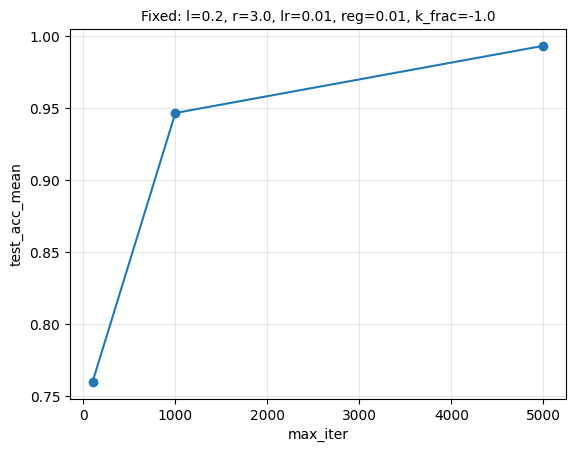

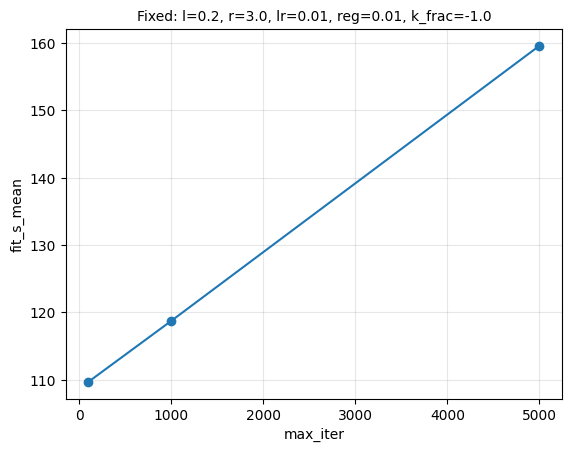

In [ ]:
fig, ax, sub = plot_two_cols_fixed(
    agg_df,
    x_col="max_iter",
    y_col="test_acc_mean",
    fixed_cols=["l", "r", "lr", "reg", "k_frac"],
    ref_idx=0,
    savepath=out_dir / f"{meta['dataset']}_plot_acc_max_iter.png",
)
plt.show()

fig, ax, sub = plot_two_cols_fixed(
    agg_df,
    x_col="max_iter",
    y_col="fit_s_mean",
    fixed_cols=["l", "r", "lr", "reg", "k_frac"],
    ref_idx=0,
    savepath=out_dir / f"{meta['dataset']}_plot_time_max_iter.png",
)
plt.show()

### Visualizations

In [32]:
def load_shapelet_model(model_name, source_path="models"):
    """
    Load a serialized tslearn LearningShapelets model.
    """
    file_path = Path(source_path) / f"{model_name}.joblib"
    if not file_path.exists():
        raise FileNotFoundError(f"Model not found: {file_path}")

    model = joblib.load(file_path)
    return model

In [43]:
# CELL 4e - Choose model to plot visual

clf = best_clf
key = best_key_str

# clf=model_store[key]

# Create vizualisation dir
viz_dir = out_dir / f"viz_{key}"
viz_dir.mkdir(exist_ok=True)
print(f"Figures will be stored at {viz_dir}")

Figures will be stored at results_shapelets_ucr/viz_k_frac_-1_l_0.2_lr_0.01_max_iter_5000_r_3_reg_0.01_seed_0


In [44]:
# CELL 5 — Plotting helpers (confusion + loss)


def plot_confusion(y_true, y_pred, title, savepath=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_loss_curve(clf, title="Training loss", savepath=None):
    hist = getattr(clf, "history_", None)
    if hist is None or "loss" not in hist:
        print("No loss history found on clf.history_.")
        return
    losses = np.asarray(hist["loss"], dtype=float)
    fig = plt.figure(figsize=(6, 3.5))
    plt.plot(np.arange(1, len(losses) + 1), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

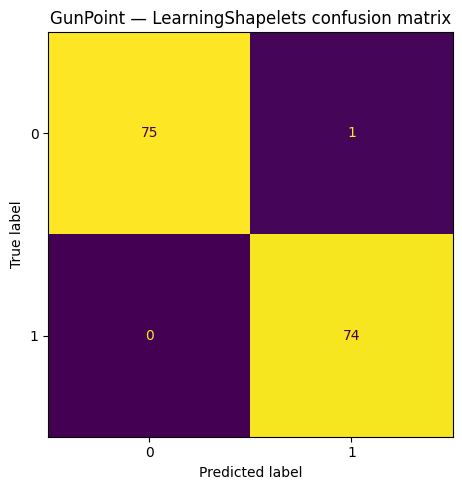

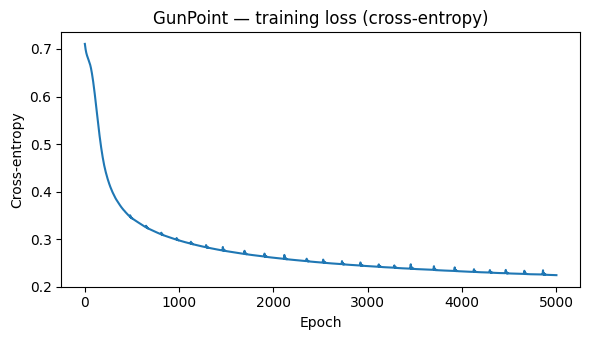

In [45]:
# CELL 5b — Use plotting helpers immediately (Plotting 1)

with device_scope(keras_device):
    y_pred = clf.predict(X_test)

plot_confusion(
    y_test,
    y_pred,
    title=f"{meta['dataset']} — LearningShapelets confusion matrix",
    savepath=viz_dir / f"{meta['dataset']}_confusion.png",
)

plot_loss_curve(
    clf,
    title=f"{meta['dataset']} — training loss (cross-entropy)",
    savepath=viz_dir / f"{meta['dataset']}_loss.png",
)

In [46]:
# CELL 6 — Shapelet interpretation helpers (importance + plots)


def get_classification_weights(clf):
    W, b = clf.get_weights("classification")
    return np.asarray(W), np.asarray(b)


def shapelet_importance_from_linear_head(W):
    if W.ndim == 1:
        return np.abs(W)
    return np.linalg.norm(W, axis=1)


def shapelet_effect_sizes(clf, X, y):
    D = clf.transform(X)
    classes = np.unique(y)
    eff = np.zeros(D.shape[1], dtype=float)
    for j in range(D.shape[1]):
        dj = D[:, j]
        best = 0.0
        for c in classes:
            in_c = dj[y == c]
            out_c = dj[y != c]
            d = cohen_d(in_c, out_c)
            if np.isfinite(d):
                best = max(best, abs(d))
        eff[j] = best
    return eff


def plot_top_shapelets(clf, top_idx, savepath=None):
    fig = plt.figure(figsize=(8, 1.9 * len(top_idx)))
    for k, j in enumerate(top_idx):
        ax = plt.subplot(len(top_idx), 1, k + 1)
        shp = np.asarray(clf.shapelets_[j]).ravel()
        ax.plot(shp)
        ax.set_title(f"Shapelet #{j} (length={len(shp)})")
        ax.set_xlim(0, len(shp) - 1)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_aligned_class_means(
    clf, X, y, shapelet_idx, n_per_class=30, title=None, savepath=None
):
    shp = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp)
    loc = clf.locate(X)

    classes = np.unique(y)
    fig = plt.figure(figsize=(7, 2.2 * len(classes)))
    for i, c in enumerate(classes):
        ax = plt.subplot(len(classes), 1, i + 1)
        idx = np.where(y == c)[0]
        if len(idx) > n_per_class:
            idx = np.random.choice(idx, size=n_per_class, replace=False)

        segs = []
        for t in idx:
            pos = int(loc[t, shapelet_idx])
            ts = X[t].ravel()
            if pos < 0:
                continue
            if pos + L <= len(ts):
                segs.append(ts[pos : pos + L])
        segs = np.asarray(segs)
        if segs.size == 0:
            ax.set_title(f"Class {c}: no segments extracted")
            continue

        m = segs.mean(axis=0)
        s = segs.std(axis=0)
        ax.plot(m, linewidth=2, label="mean aligned segment")
        ax.fill_between(np.arange(L), m - s, m + s, alpha=0.2, label="±1 std")
        ax.plot(shp, linewidth=2, linestyle="--", label="shapelet")
        ax.set_title(
            f"Class {c}: aligned segments vs shapelet (j={shapelet_idx}, L={L})"
        )
        ax.set_xlim(0, L - 1)
        ax.legend(loc="upper right", fontsize=9)

    if title:
        fig.suptitle(title, y=1.02)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


def plot_location_histograms(clf, X, y, shapelet_idx, bins=20, savepath=None):
    loc = clf.locate(X)
    positions = loc[:, shapelet_idx].astype(int)
    classes = np.unique(y)

    fig = plt.figure(figsize=(7, 2.2 * len(classes)))
    for i, c in enumerate(classes):
        ax = plt.subplot(len(classes), 1, i + 1)
        pos_c = positions[y == c]
        ax.hist(pos_c, bins=bins, alpha=0.8)
        ax.set_title(f"Match locations for shapelet #{shapelet_idx} in class {c}")
        ax.set_xlabel("Best-match start index")
        ax.set_ylabel("count")
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_distance_space_first2shapelets(clf, X, y, title, savepath=None):
    """
    Plot each time series in the 2D 'shapelet-distance space' defined by the
    FIRST TWO learned shapelets:
        (d(x, s1), d(x, s2))

    Requires: clf has at least 2 shapelets.
    """
    D = clf.transform(X)  # (N, K) where K = n_shapelets
    if D.shape[1] < 2:
        raise ValueError(
            f"Need at least 2 shapelets, but clf.transform(X) has shape {D.shape}"
        )

    Z = D[:, :2]  # use distances to first two shapelets directly

    fig = plt.figure(figsize=(6, 5))
    for c in np.unique(y):
        m = y == c
        plt.scatter(Z[m, 0], Z[m, 1], edgecolors="k", alpha=0.9, label=f"class {c}")

    plt.xlabel(r"$d(\mathbf{x}, \mathbf{s}_1)$")
    plt.ylabel(r"$d(\mathbf{x}, \mathbf{s}_2)$")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=200)

    plt.show()


def plot_distance_space_pca(clf, X, y, title, savepath=None):
    D = clf.transform(X)
    Z = PCA(n_components=2, random_state=0).fit_transform(D)

    fig = plt.figure(figsize=(6, 5))
    for c in np.unique(y):
        m = y == c
        plt.scatter(Z[m, 0], Z[m, 1], edgecolors="k", alpha=0.9, label=f"class {c}")
    plt.xlabel("PC1 (distances)")
    plt.ylabel("PC2 (distances)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

Top shapelets by linear-head importance (and effect size):
 shapelet_idx  length  importance_linear_head  separation_effect_max_abs_cohen_d
            5      60                1.645976                           1.155527
            0      30                1.588917                           1.517860
            7      90                0.917867                           0.573964
            6      90                0.836756                           0.526661
            4      60                0.724912                           0.530645
            3      60                0.668943                           0.801061
            8      90                0.634318                           0.483788
            1      30                0.309965                           1.147473
            2      30                0.261624                           2.858908


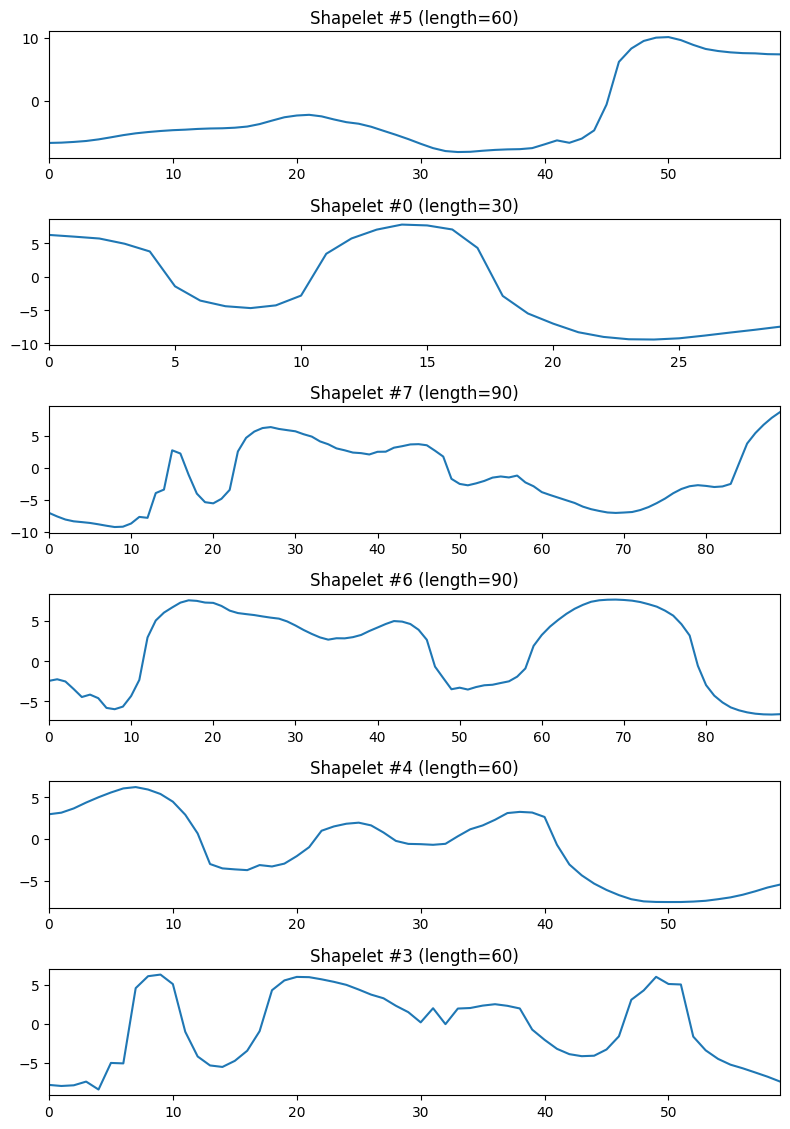

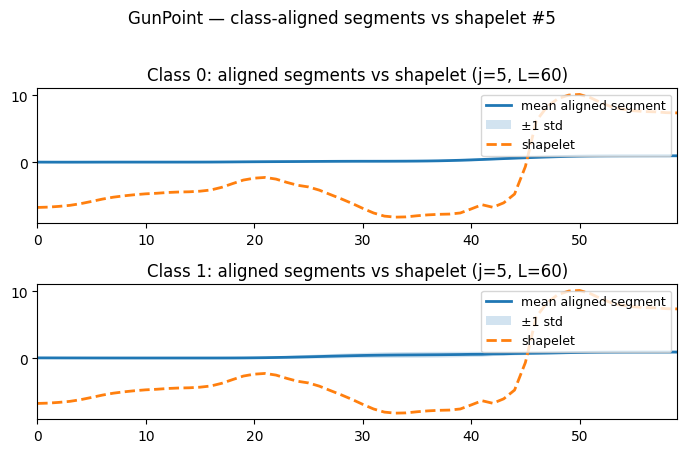

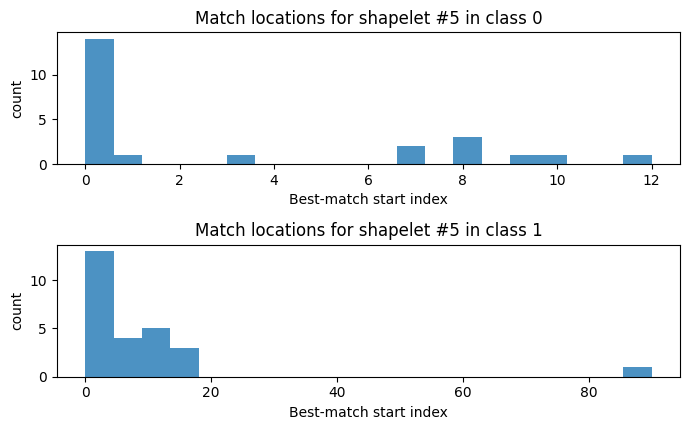

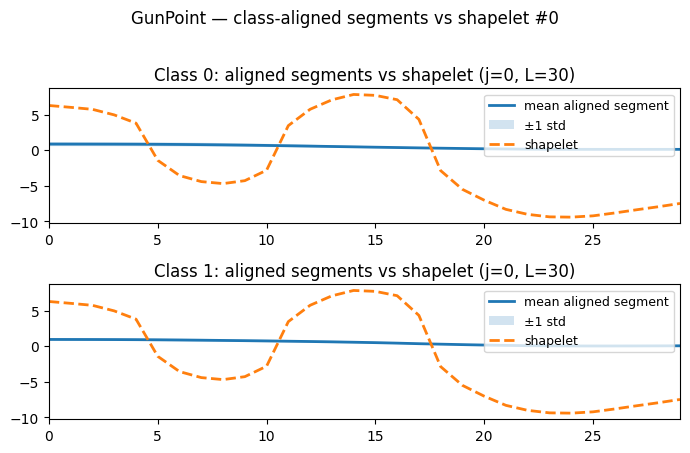

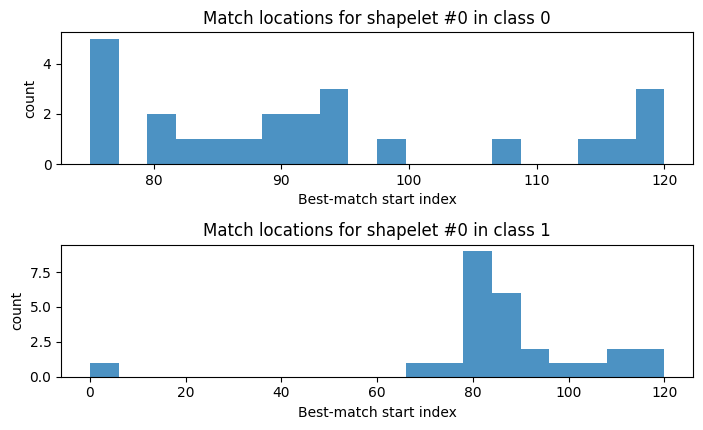

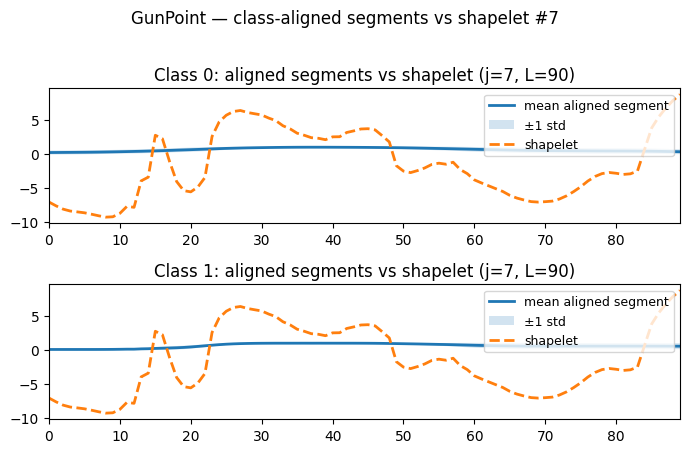

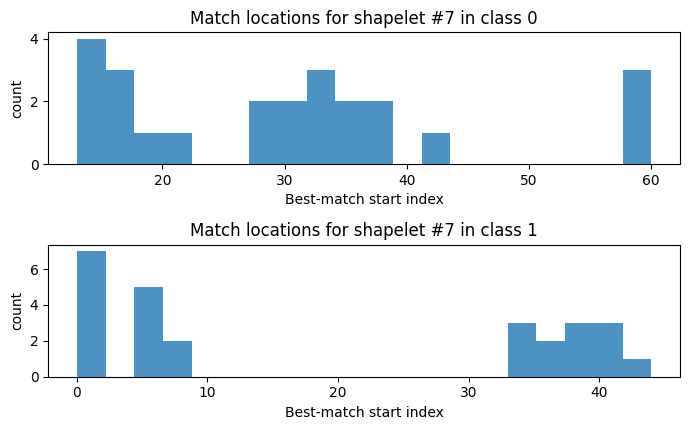

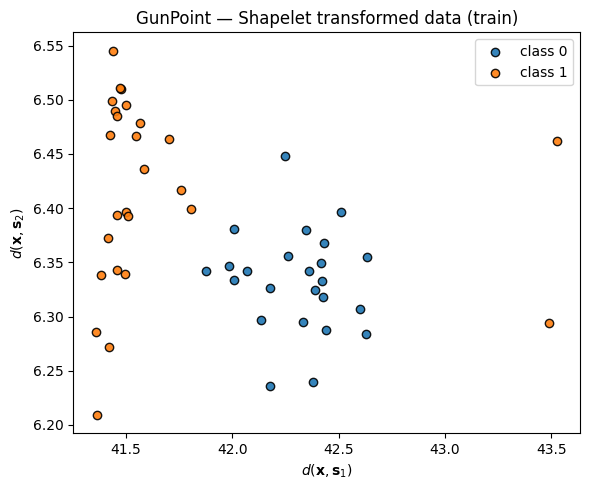

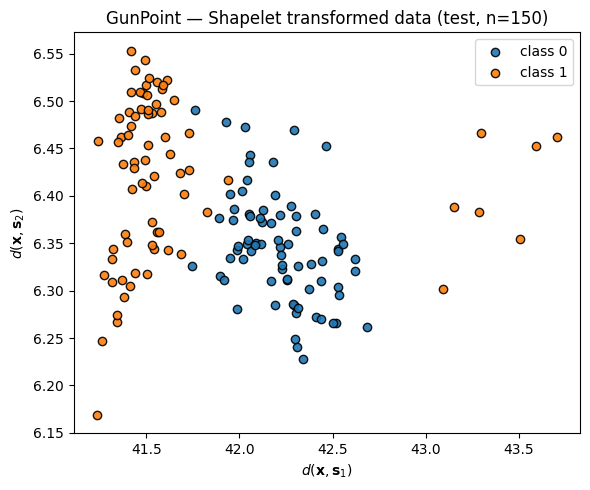

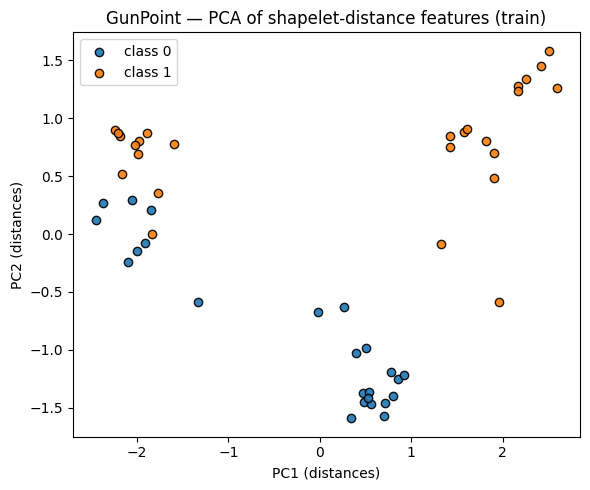

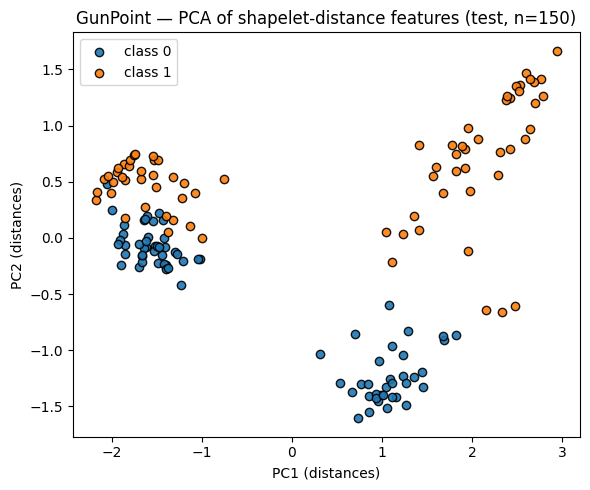

In [ ]:
# CELL 6b — Use interpretation helpers immediately (Plotting 2 + Plotting 3)

with device_scope(keras_device):
    W, b = get_classification_weights(clf)

    imp_w = shapelet_importance_from_linear_head(W)
    eff = shapelet_effect_sizes(clf, X_train, y_train)

    imp_df = pd.DataFrame(
        {
            "shapelet_idx": np.arange(len(imp_w)),
            "length": [len(np.asarray(s).ravel()) for s in clf.shapelets_],
            "importance_linear_head": imp_w,
            "separation_effect_max_abs_cohen_d": eff,
        }
    ).sort_values(
        ["importance_linear_head", "separation_effect_max_abs_cohen_d"], ascending=False
    )
    imp_df.to_csv(viz_dir / f"{meta['dataset']}_shapelet_importance.csv", index=False)

    print("Top shapelets by linear-head importance (and effect size):")
    print(imp_df.head(10).to_string(index=False))

    top_k = min(6, len(imp_df))
    top_idx = imp_df["shapelet_idx"].head(top_k).to_numpy()

    plot_top_shapelets(
        clf,
        top_idx,
        savepath=viz_dir / f"{meta['dataset']}_top_shapelets.png",
    )

    # plot for top shapelet
    # j = int(top_idx[0])
    for j in top_idx[: min(len(top_idx), 3)]:
        j = int(j)
        plot_aligned_class_means(
            clf,
            X_train,
            y_train,
            shapelet_idx=j,
            title=f"{meta['dataset']} — class-aligned segments vs shapelet #{j}",
            savepath=viz_dir / f"{meta['dataset']}_aligned_means_shapelet{j}.png",
        )

        plot_location_histograms(
            clf,
            X_train,
            y_train,
            shapelet_idx=j,
            savepath=viz_dir / f"{meta['dataset']}_locations_shapelet{j}.png",
        )

    # plot distance space
    plot_distance_space_first2shapelets(
        clf,
        X_train,
        y_train,
        title=f"{meta['dataset']} — Shapelet transformed data (train)",
        savepath=viz_dir / f"{meta['dataset']}_shapelet_distance_train.png",
    )

    plot_distance_space_first2shapelets(
        clf,
        X_test,
        y_test,
        title=f"{meta['dataset']} — Shapelet transformed data (test, n={len(y_test)})",
        savepath=viz_dir / f"{meta['dataset']}_shapelet_distance_test.png",
    )

    plot_distance_space_pca(
        clf,
        X_train,
        y_train,
        title=f"{meta['dataset']} — PCA of shapelet-distance features (train)",
        savepath=viz_dir / f"{meta['dataset']}_pca_distance_train.png",
    )

    plot_distance_space_pca(
        clf,
        X_test,
        y_test,
        title=f"{meta['dataset']} — PCA of shapelet-distance features (test, n={len(y_test)})",
        savepath=viz_dir / f"{meta['dataset']}_pca_distance_test.png",
    )

In [48]:
# CELL 6c
def _sliding_window_view_1d(x, L):
    """Compat helper: return shape (Q-L+1, L) windows."""
    try:
        return np.lib.stride_tricks.sliding_window_view(x, L)
    except Exception:
        # fallback (slower but robust)
        Q = len(x)
        return np.vstack([x[t : t + L] for t in range(Q - L + 1)])


def _distance_profile_mse(ts, shp_raw):
    """
    Model-faithful-ish distance profile: per-window mean squared error
    D_t = (1/L) * sum_{ell=1..L} (ts[t+ell] - shp[ell])^2
    """
    ts = np.asarray(ts).ravel()
    shp_raw = np.asarray(shp_raw).ravel()
    L = len(shp_raw)
    W = _sliding_window_view_1d(ts, L)  # (Q-L+1, L)
    return ((W - shp_raw) ** 2).mean(axis=1)


def _distance_profile_l2(ts, shp_plot):
    """Visualization distance profile: per-window L2 norm."""
    ts = np.asarray(ts).ravel()
    shp_plot = np.asarray(shp_plot).ravel()
    L = len(shp_plot)
    W = _sliding_window_view_1d(ts, L)
    return np.linalg.norm(W - shp_plot, axis=1)


def _softmin_from_profile(D, alpha=-100.0):
    """
    Soft-min of a distance profile D using weights exp(alpha * D).
    Stable implementation (shift in exponent).
    Returns scalar.
    """
    D = np.asarray(D, dtype=float)
    u = alpha * D
    u = u - np.max(u)  # stability
    w = np.exp(u)
    return float(np.sum(D * w) / (np.sum(w) + 1e-12))


def plot_shapelet_on_best_matches(
    clf,
    X,
    y=None,
    shapelet_idx=0,
    n_examples=6,
    per_class=True,
    pick="closest",  # "closest" or "random"
    seed=0,
    rescale_shapelet="none",  # "none" or "minmax"
    show_distance_curve=None,  # None/False, "l2", "softmin", or "both"
    alpha=-100.0,  # used for soft-min annotation in "softmin"/"both"
    savepath=None,
):
    """
    Plot one shapelet overlaid on several time series at the model best-match location.

    Layout (ONE example per block, axes aligned in x):
      - always: "best match overlay"
      - if show_distance_curve == "softmin": add softmin/MSE profile below
      - if show_distance_curve == "l2": add L2 profile below
      - if show_distance_curve == "both": add 2 profiles below (3 rows total)

    X-axis alignment:
      - overlay uses time index 0..Q-1
      - distance profiles are plotted against window START index (0..Q-L),
        but we set xlim to 0..Q-1 so the dashed vertical lines align with overlay.
    """
    rng = np.random.default_rng(seed)

    # raw shapelet (1D)
    shp_raw = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp_raw)

    # model distances + locations
    D_all = clf.transform(X)  # (n_samples, n_shapelets)
    loc = clf.locate(X)  # (n_samples, n_shapelets)
    dist_j = D_all[:, shapelet_idx]
    pos_j = loc[:, shapelet_idx].astype(int)

    # choose indices to plot
    if per_class and (y is not None):
        classes = np.unique(y)
        k = int(np.ceil(n_examples / len(classes)))
        chosen = []
        for c in classes:
            idx_c = np.where(y == c)[0]
            if len(idx_c) == 0:
                continue
            if pick == "closest":
                order = idx_c[np.argsort(dist_j[idx_c])]
                chosen.extend(order[: min(k, len(order))].tolist())
            elif pick == "random":
                chosen.extend(
                    rng.choice(idx_c, size=min(k, len(idx_c)), replace=False).tolist()
                )
            else:
                raise ValueError("pick must be 'closest' or 'random'")
        chosen = chosen[:n_examples]
    else:
        idx_all = np.arange(X.shape[0])
        if pick == "closest":
            chosen = idx_all[np.argsort(dist_j)][:n_examples].tolist()
        elif pick == "random":
            chosen = rng.choice(
                idx_all, size=min(n_examples, len(idx_all)), replace=False
            ).tolist()
        else:
            raise ValueError("pick must be 'closest' or 'random'")

    # shapelet for plotting
    if rescale_shapelet == "minmax":
        shp_plot = (
            TimeSeriesScalerMinMax().fit_transform(shp_raw.reshape(1, -1, 1)).ravel()
        )
    elif rescale_shapelet == "none":
        shp_plot = shp_raw
    else:
        raise ValueError("rescale_shapelet must be 'none' or 'minmax'")

    # how many rows per example
    if not show_distance_curve:
        rows_per_ex = 1
        modes = []
    elif show_distance_curve == "l2":
        rows_per_ex = 2
        modes = ["l2"]
    elif show_distance_curve == "softmin":
        rows_per_ex = 2
        modes = ["softmin"]
    elif show_distance_curve == "both":
        rows_per_ex = 3
        modes = ["softmin", "l2"]
    else:
        raise ValueError(
            "show_distance_curve must be None/False, 'l2', 'softmin', or 'both'"
        )

    n = len(chosen)
    nrows = n * rows_per_ex
    fig_h = (2.4 + (1.6 * (rows_per_ex - 1))) * max(1, n)
    fig, axes = plt.subplots(nrows, 1, figsize=(12, fig_h), squeeze=False)

    def ax_block(example_idx, subrow):
        """subrow: 0=overlay, 1=softmin OR l2 (if rows_per_ex==2), 2=l2 (if rows_per_ex==3)."""
        return axes[example_idx * rows_per_ex + subrow, 0]

    for ex, i in enumerate(chosen):
        ts = np.asarray(X[i]).ravel()
        Q = len(ts)

        # model best-match start index
        pos_model = int(pos_j[i])
        pos_model = max(0, min(pos_model, Q - L))

        # ----- Row 1: overlay -----
        ax0 = ax_block(ex, 0)
        ax0.plot(ts, linewidth=1.2)
        ax0.axvline(pos_model, linestyle="--", alpha=0.35, label="model locate")
        ax0.plot(np.arange(pos_model, pos_model + L), shp_plot, linewidth=2)

        label_str = f"idx={i}, d_model={dist_j[i]:.4f}"
        if y is not None:
            label_str += f", y={y[i]}"
        ax0.set_title(
            f"Best match overlay ({label_str}), pick={pick}, shapelet_idx={shapelet_idx}, L={L}"
        )
        ax0.set_xlim(0, Q - 1)

        # share x within the block
        if rows_per_ex > 1:
            ax1 = ax_block(ex, 1)
            ax1.sharex(ax0)
        if rows_per_ex > 2:
            ax2 = ax_block(ex, 2)
            ax2.sharex(ax0)

        # ----- Rows below: profiles -----
        if show_distance_curve:
            # Softmin/MSE profile (raw shapelet)
            if "softmin" in modes:
                ax_s = ax_block(ex, 1 if rows_per_ex == 3 else 1)
                dcurve = _distance_profile_mse(ts, shp_raw)
                xw = np.arange(len(dcurve))  # window start indices
                pos_curve = int(np.argmin(dcurve))
                hard = float(np.min(dcurve))
                soft = _softmin_from_profile(dcurve, alpha=alpha)

                ax_s.plot(xw, dcurve, linewidth=1.2)
                ax_s.axvline(
                    pos_curve,
                    linestyle="--",
                    alpha=0.35,
                    label="argmin (hard-min)",
                    color="green",
                )
                ax_s.axvline(
                    pos_model,
                    linestyle=":",
                    alpha=0.35,
                    label="model locate",
                    color="orange",
                )
                # ax_s.axhline(hard, linestyle=":", alpha=0.45, label="hard-min value")
                # ax_s.axhline(soft, linestyle="-.", alpha=0.55, label="soft-min value")
                ax_s.set_title(
                    f"Softmin view (MSE profile, raw shapelet): hard={hard:.4g}, soft={soft:.4g} (α={alpha:g})"
                )
                ax_s.set_xlim(0, Q - 1)
                ax_s.legend(loc="upper left", fontsize=8)

            # L2 profile (plotted shapelet)
            if "l2" in modes:
                ax_l = ax_block(ex, 2 if rows_per_ex == 3 else 1)
                dcurve = _distance_profile_l2(ts, shp_plot)
                xw = np.arange(len(dcurve))
                pos_curve = int(np.argmin(dcurve))
                hard = float(np.min(dcurve))

                ax_l.plot(xw, dcurve, linewidth=1.2)
                ax_l.axvline(pos_curve, linestyle="--", alpha=0.35, label="argmin (L2)")
                ax_l.axvline(pos_model, linestyle=":", alpha=0.35, label="model locate")
                ax_l.set_title(
                    f"L2 view (vs plotted shapelet, rescale={rescale_shapelet}): min={hard:.4g}"
                )
                ax_l.set_xlim(0, Q - 1)
                ax_l.set_xlabel("time / window start index")
                ax_l.legend(loc="upper left", fontsize=8)

        # tiny legend on overlay
        ax0.legend(loc="upper left", fontsize=8)

    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()
    return chosen

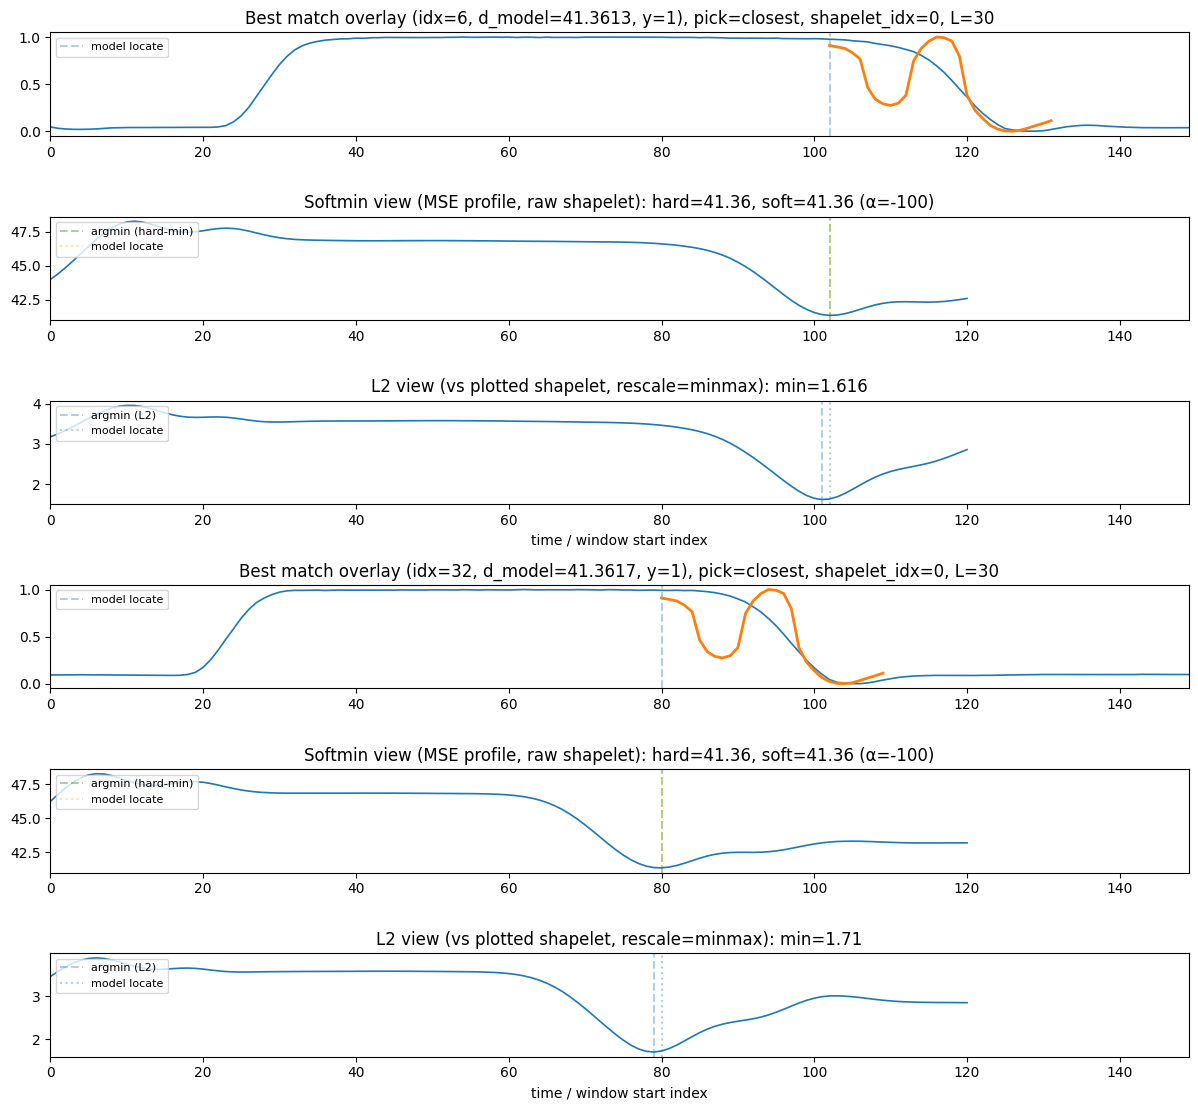

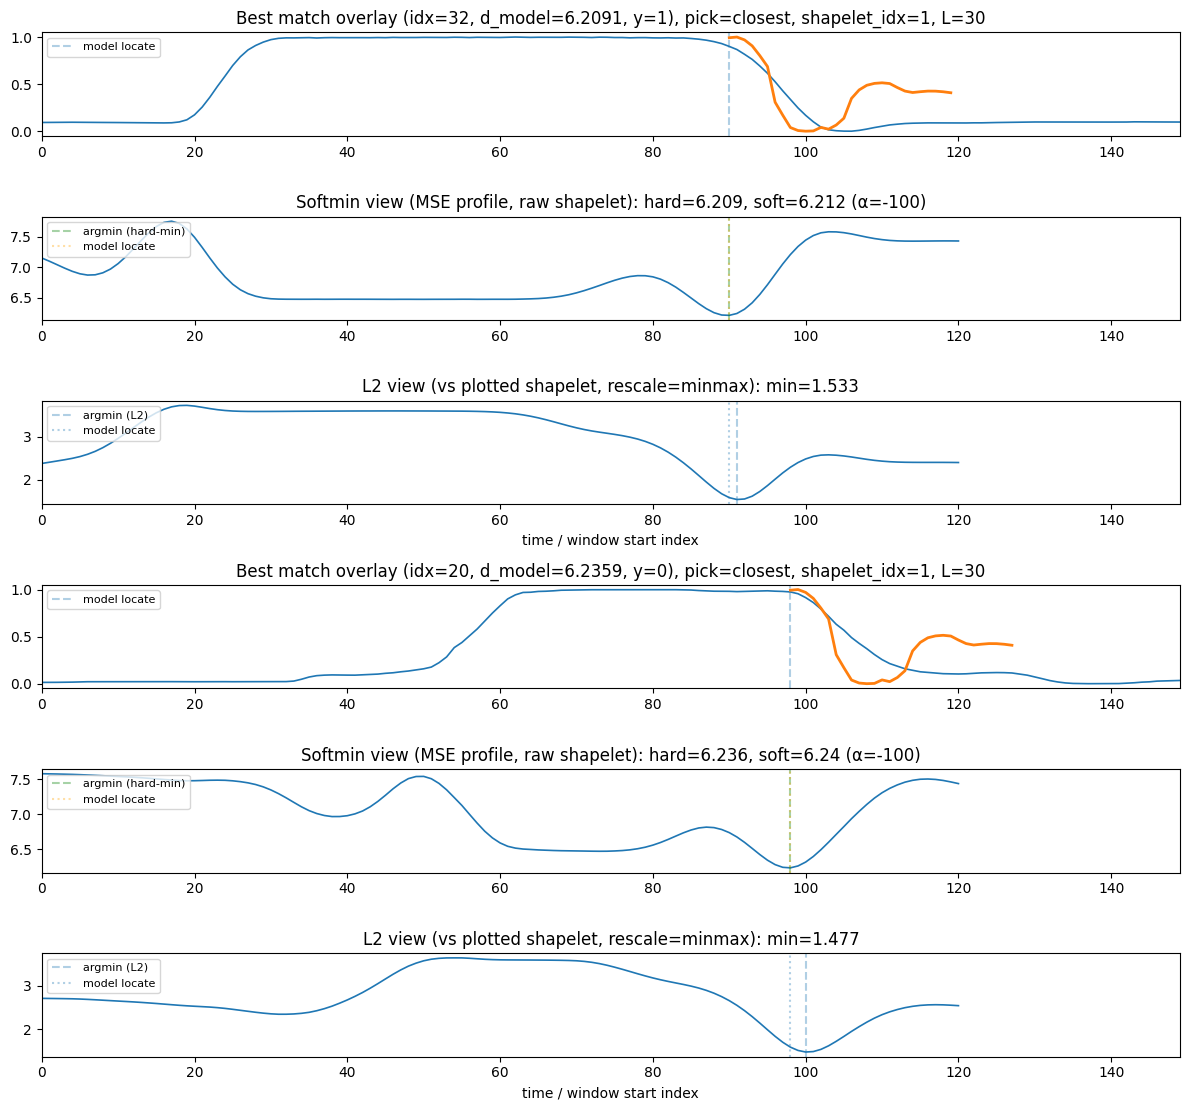

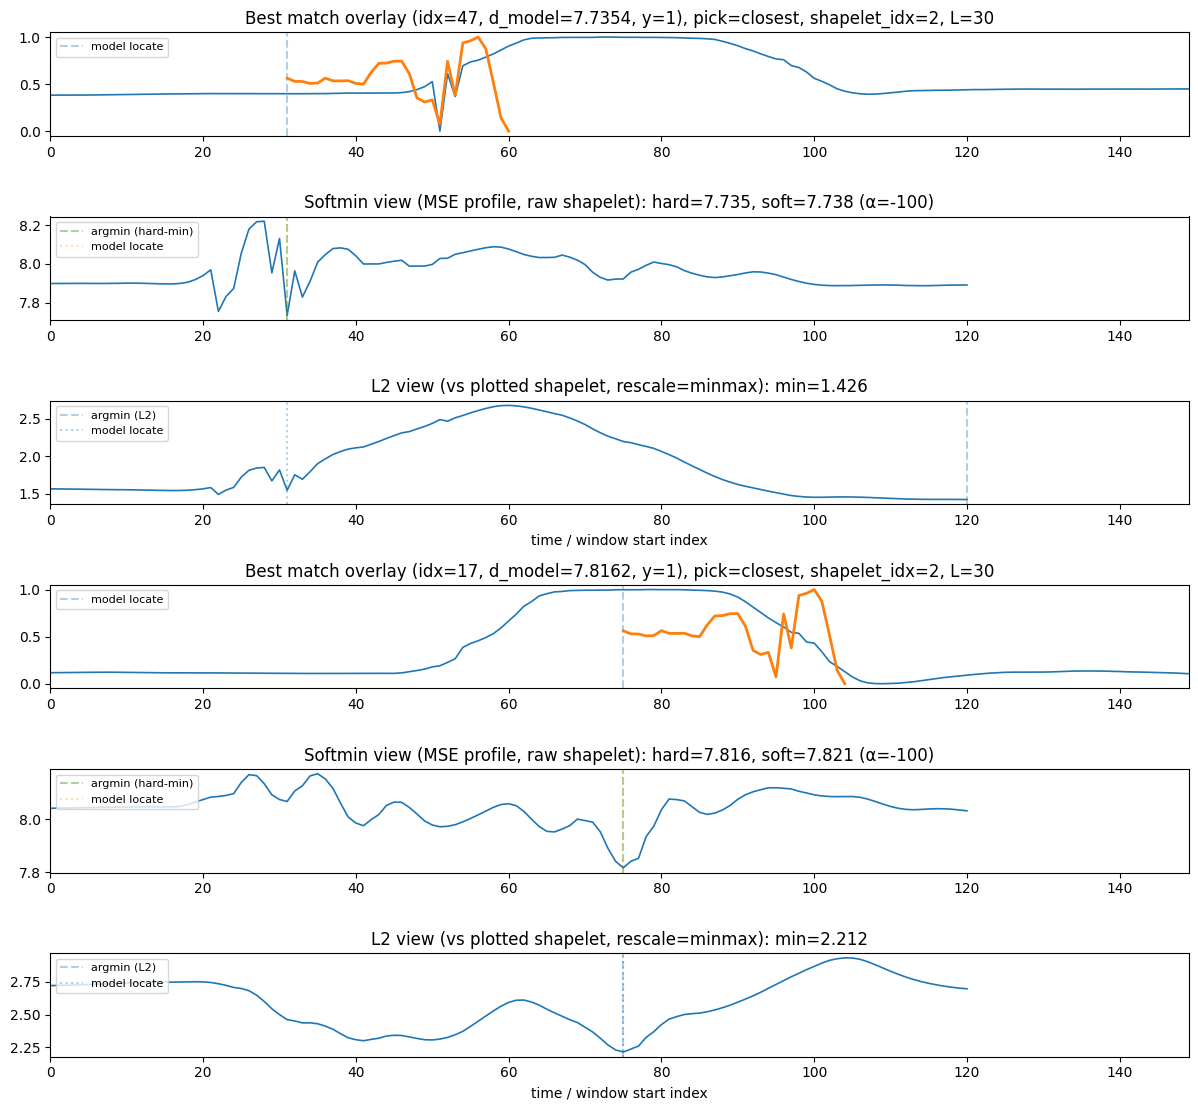

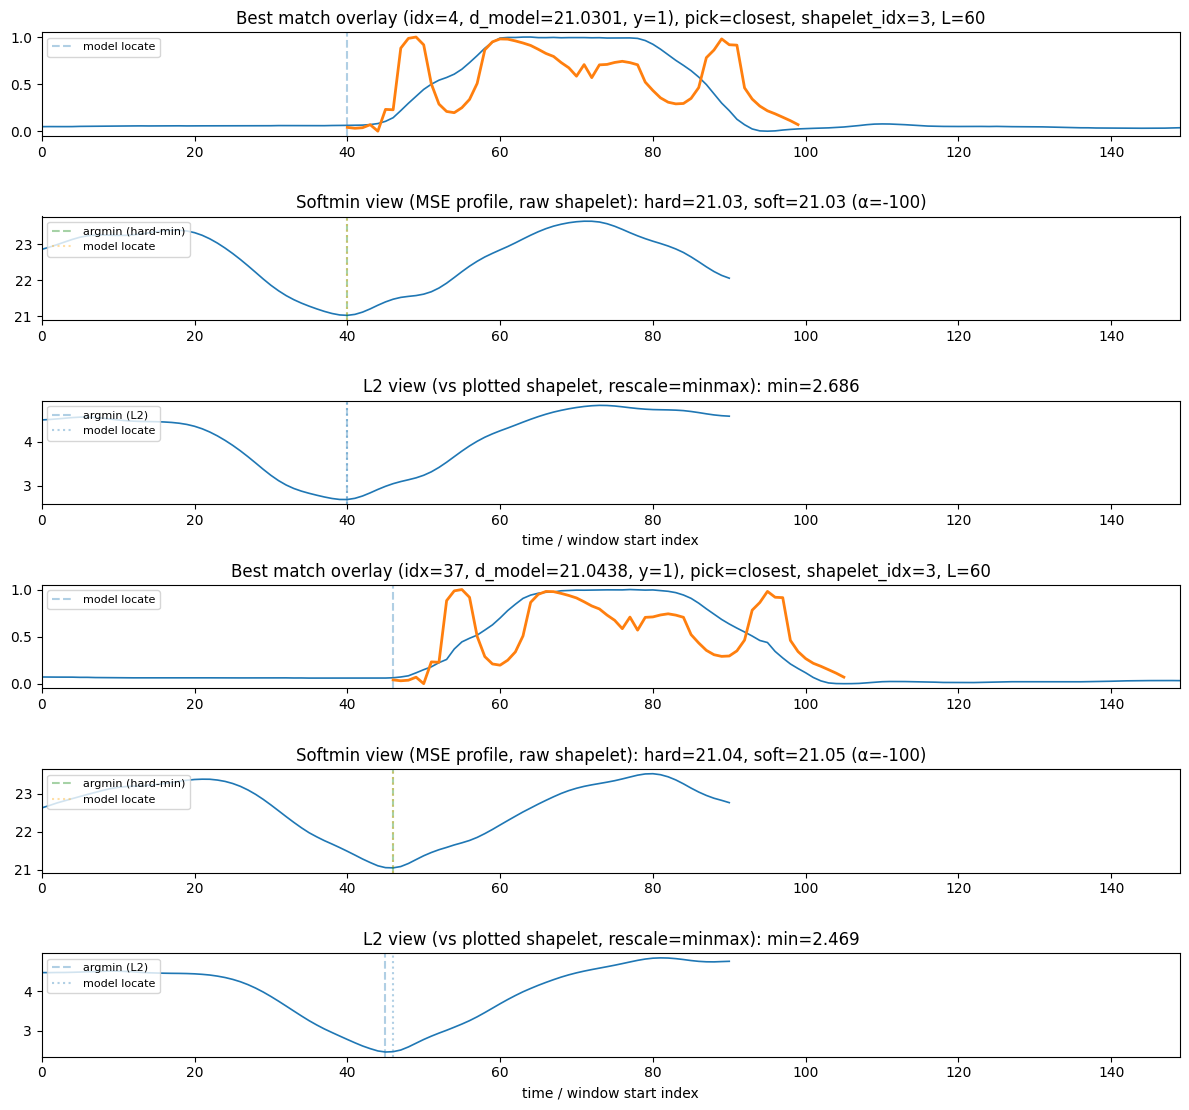

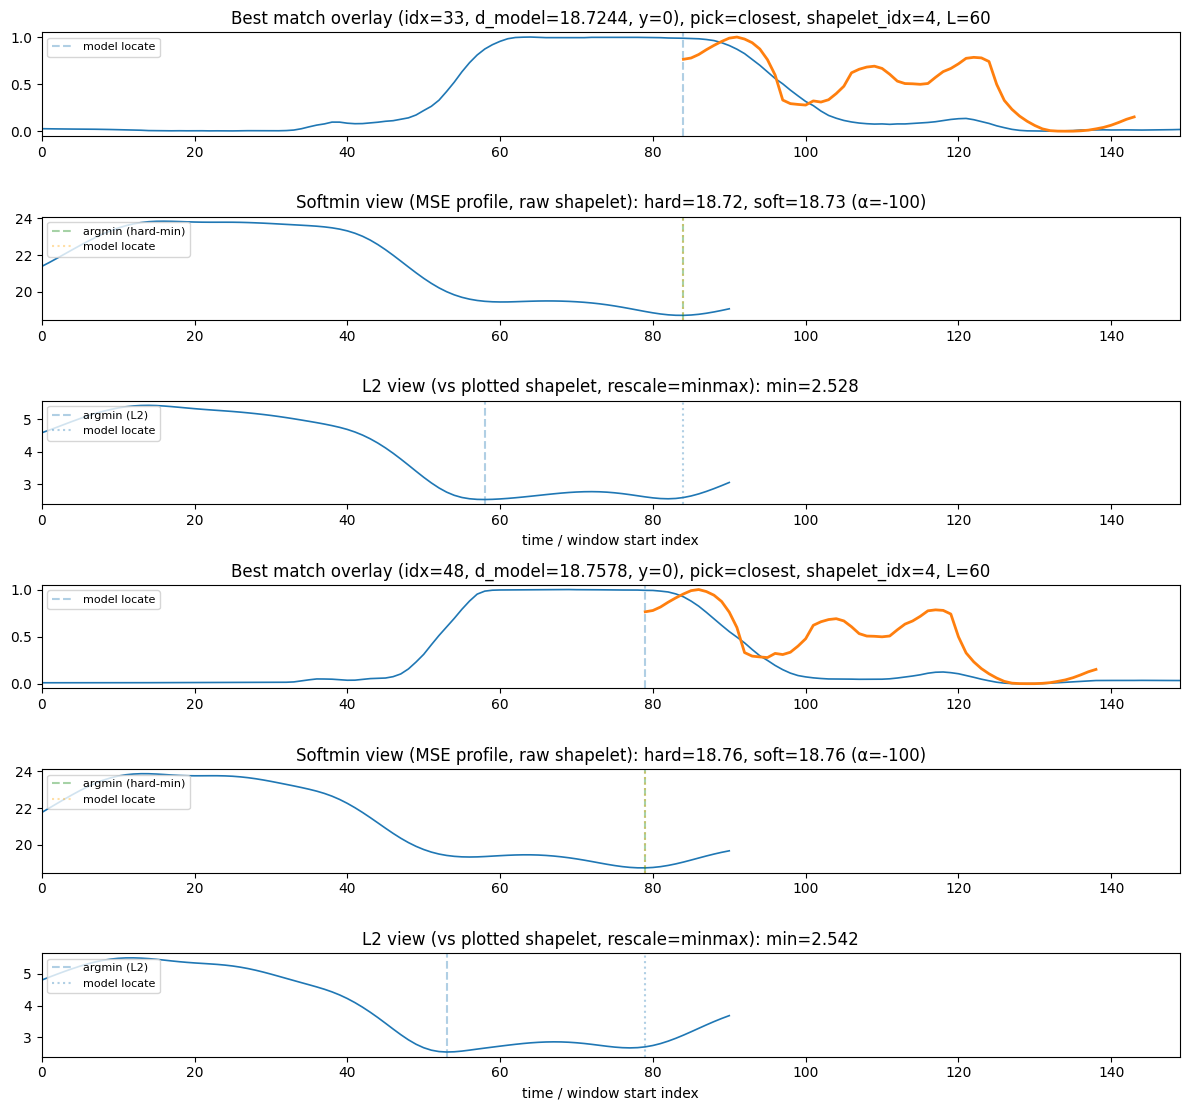

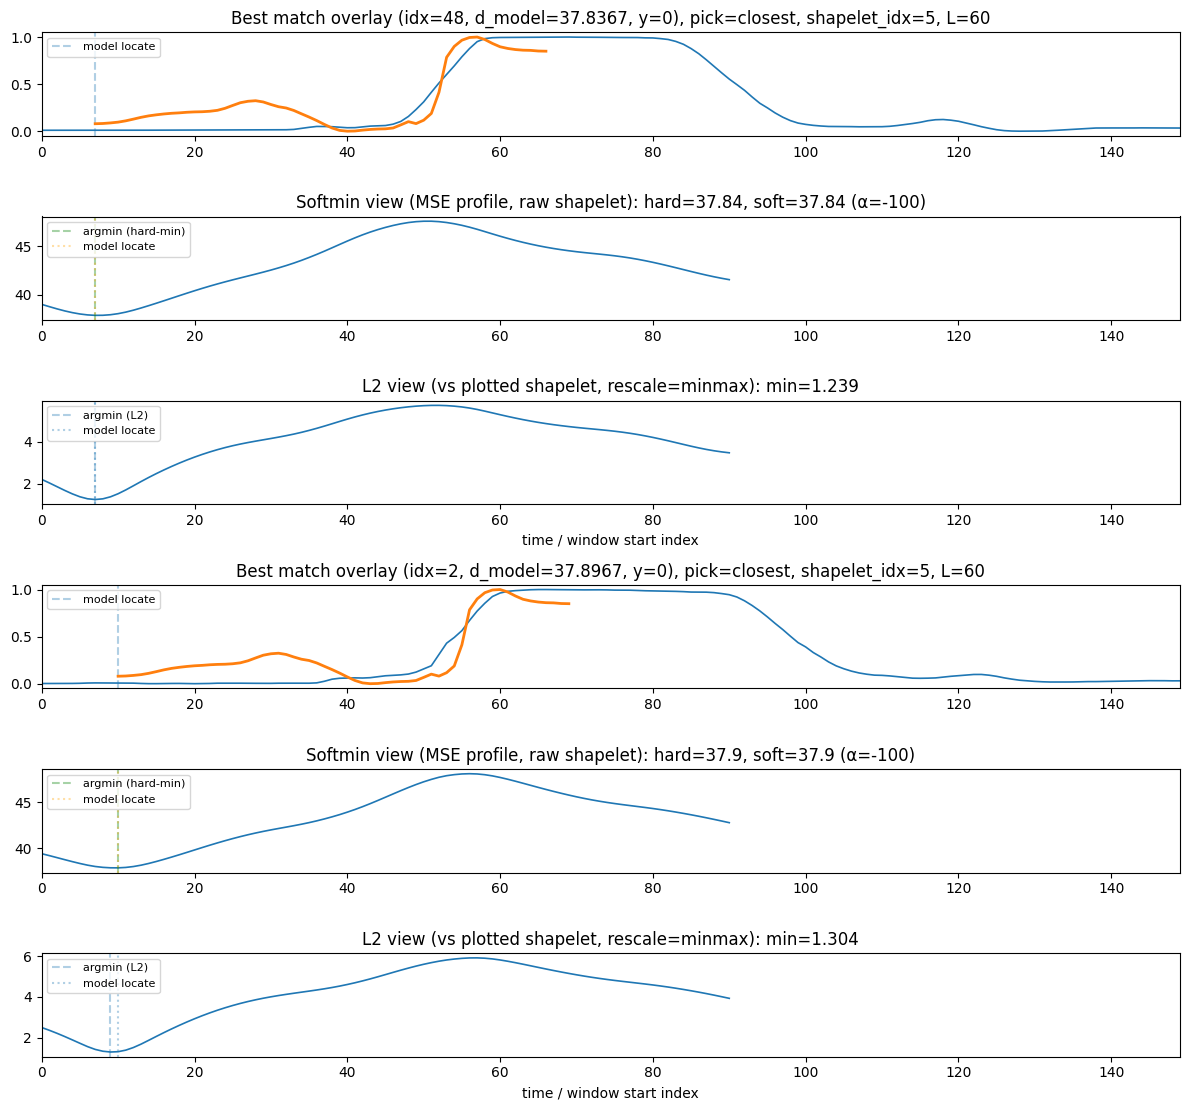

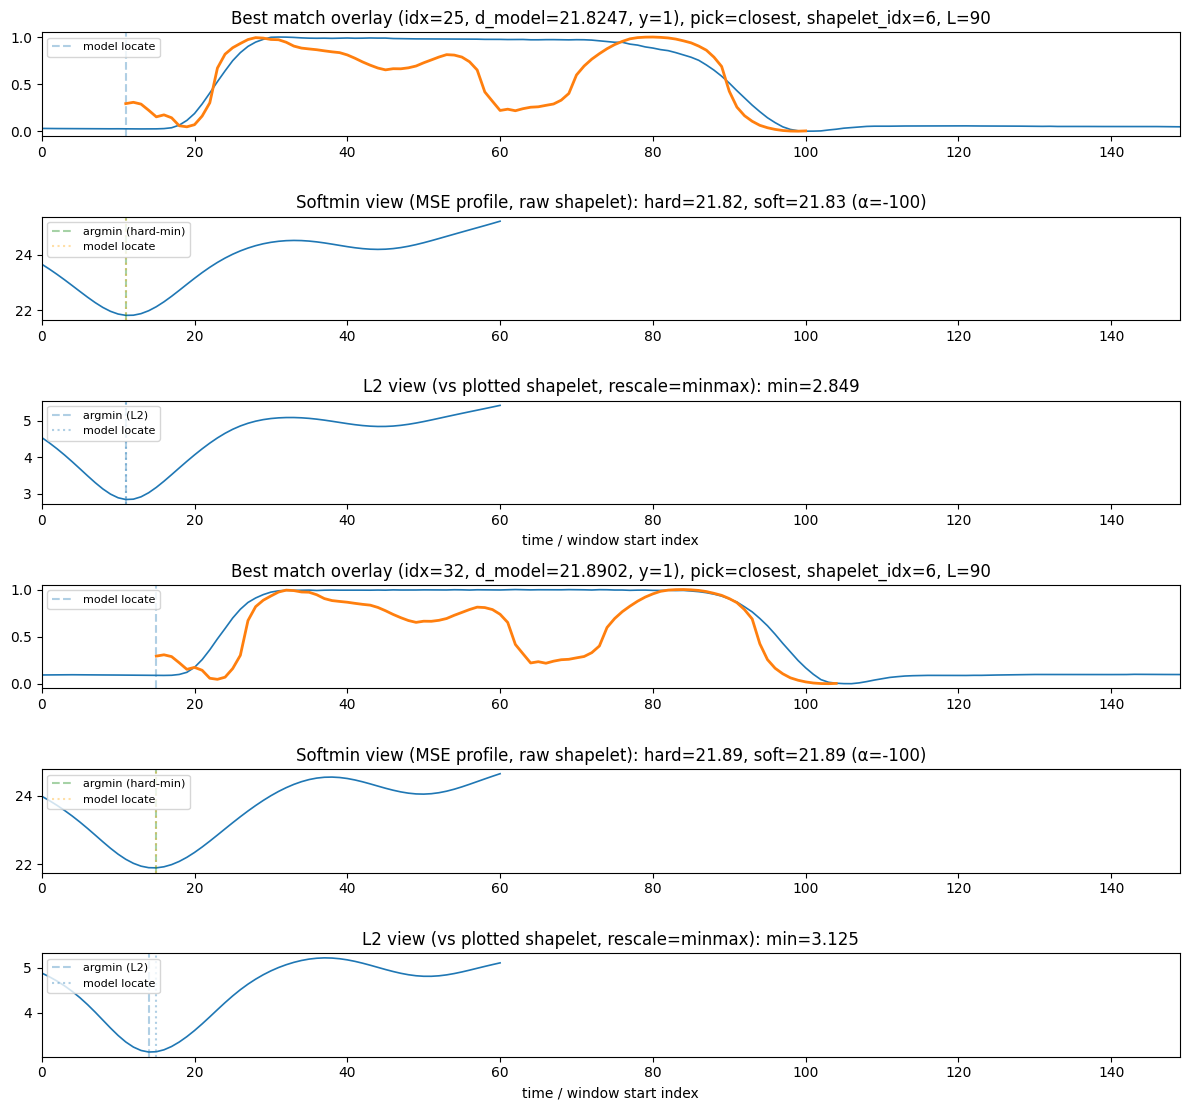

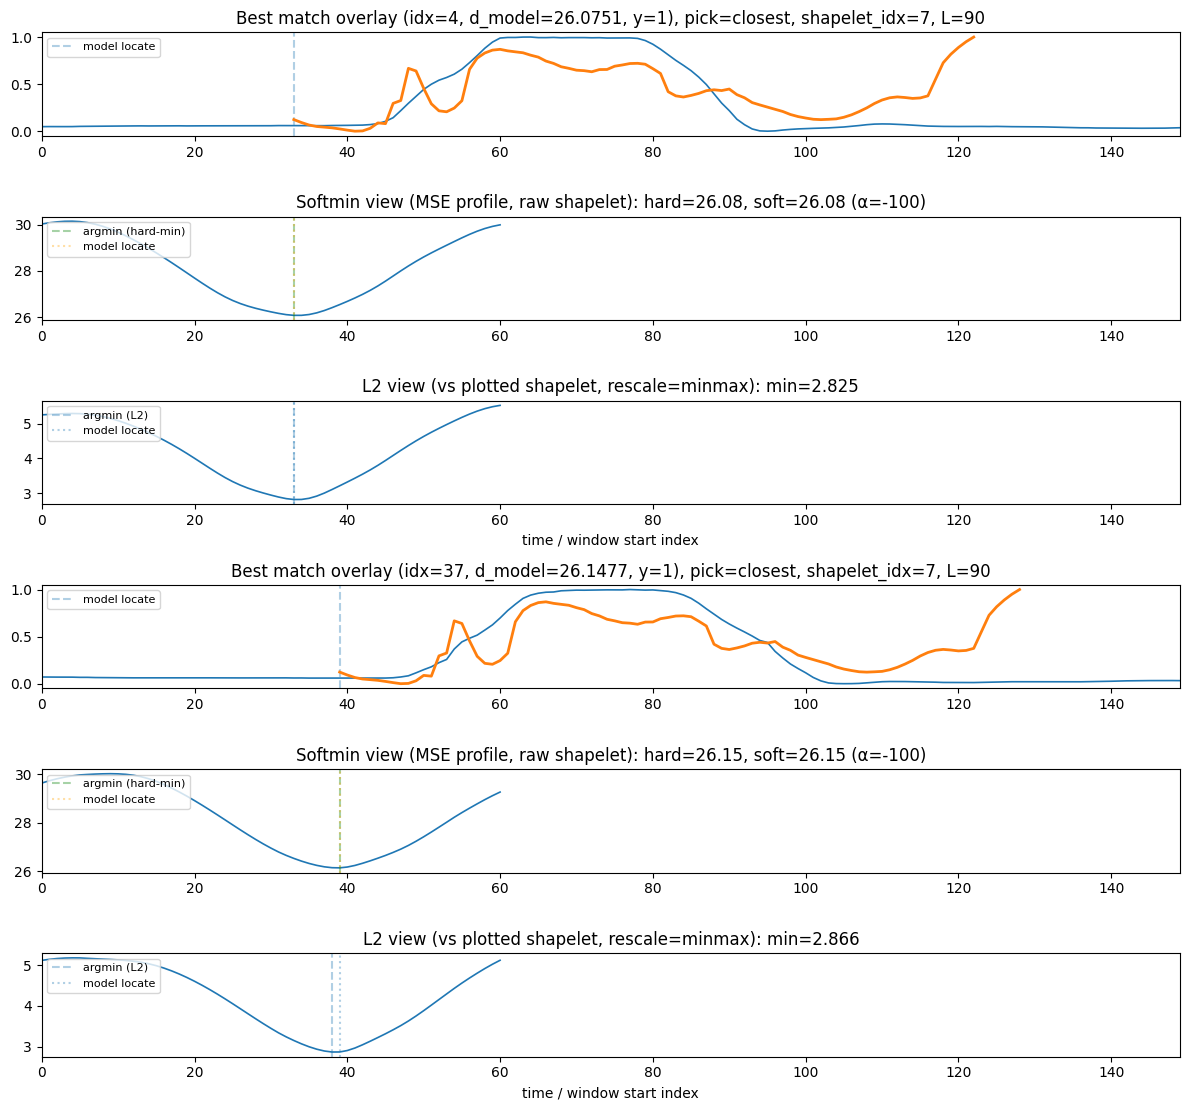

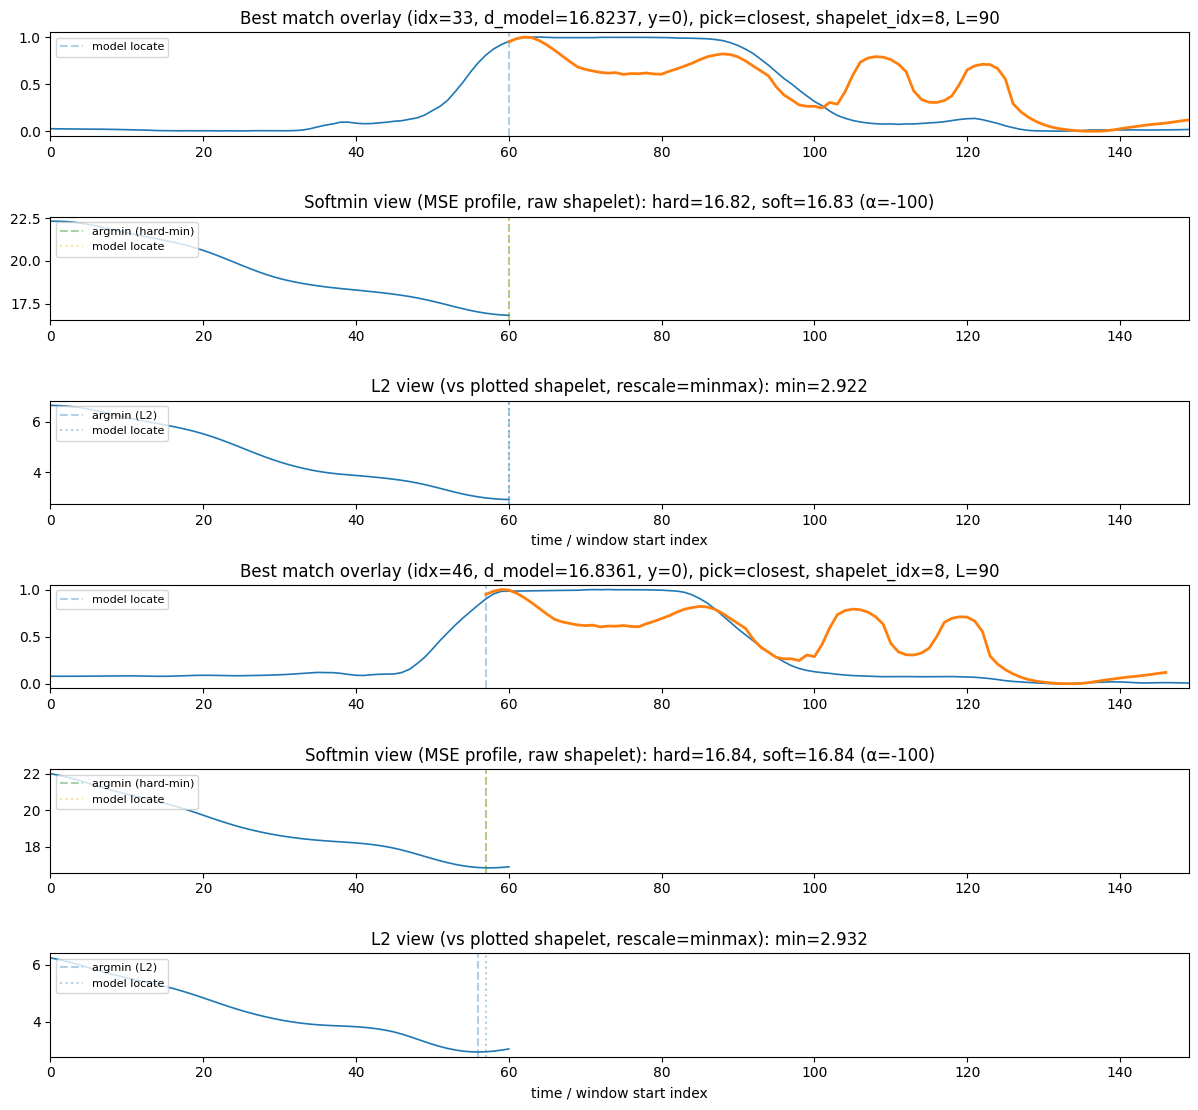

In [49]:
with device_scope(keras_device):
    for shapelet_idx in range(len(clf.shapelets_)):
        # show the most convincing matches, split per class
        plot_shapelet_on_best_matches(
            clf,
            X_train,
            y=y_train,
            shapelet_idx=shapelet_idx,
            n_examples=2,
            per_class=False,
            pick="closest",
            rescale_shapelet="minmax",  # or "none"
            show_distance_curve="both",  # set True if you want the distance curve panel
            savepath=viz_dir / f"shapelet_on_best_match_shp_idx_{shapelet_idx}_a.png",
        )

        # # show random matches (still aligned), to check how universal the motif is
        # plot_shapelet_on_best_matches(
        #     clf,
        #     X_train,
        #     y=y_train,
        #     shapelet_idx=shapelet_idx,
        #     n_examples=1,
        #     per_class=True,
        #     pick="random",
        #     seed=0,
        #     rescale_shapelet="minmax",
        #     show_distance_curve="both",  # set True if you want the distance curve panel
        # )

In [50]:
# CELL 6d
import numpy as np
import matplotlib.pyplot as plt


def plot_shapelet_distance_distribution(
    clf,
    X,
    y=None,
    shapelet_idx=0,
    title=None,
    bins=40,
    show_percentiles=(1, 5, 10, 25, 50, 75, 90, 95, 99),
    highlight_indices=None,  # list/array of sample indices to mark
    figsize=(10, 4),
    savepath=None,
):
    """
    Plot dataset-wide distribution of the model distance to one shapelet.

    Distances come from clf.transform(X)[:, shapelet_idx] (i.e., the model feature).

    Also prints/annotates percentiles, and can highlight specific samples with
    their distance + percentile rank.

    Parameters
    ----------
    y : optional labels
        If provided, overlays per-class distributions (simple line histograms) + legend.
    highlight_indices : optional
        Indices i to mark on the distribution and report their percentile rank.
    """
    # ensure X is accepted by clf.transform (tslearn expects (N,Q,dim))
    D = np.asarray(clf.transform(X))  # (N, K)
    dj = np.asarray(D[:, shapelet_idx], dtype=float)
    dj = dj[np.isfinite(dj)]
    if dj.size == 0:
        raise ValueError("No finite distances found (dj is empty).")

    # percentiles
    pct_vals = {p: float(np.percentile(dj, p)) for p in show_percentiles}

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    # main histogram
    ax.hist(dj, bins=bins, density=True, alpha=0.35, edgecolor="k", linewidth=0.3)

    # optional per-class overlays
    if y is not None:
        y = np.asarray(y)
        classes = np.unique(y)
        for c in classes:
            dj_c = np.asarray(D[y == c, shapelet_idx], dtype=float)
            dj_c = dj_c[np.isfinite(dj_c)]
            if dj_c.size == 0:
                continue
            ax.hist(
                dj_c,
                bins=bins,
                density=True,
                histtype="step",
                linewidth=1.5,
                label=f"class {c} (n={dj_c.size})",
            )

    # percentile lines
    ymax = ax.get_ylim()[1]
    for p, v in pct_vals.items():
        ax.axvline(v, linestyle="--", alpha=0.45)
        ax.text(v, 0.98 * ymax, f"{p}%", rotation=90, va="top", ha="right", fontsize=8)

    # highlight specific samples
    reports = []
    if highlight_indices is not None:
        highlight_indices = np.asarray(highlight_indices, dtype=int).ravel()
        D_full = np.asarray(D[:, shapelet_idx], dtype=float)
        # for percentile rank: fraction of dataset distances <= value
        # (ties handled naturally)
        for i in highlight_indices:
            if i < 0 or i >= D_full.shape[0] or not np.isfinite(D_full[i]):
                continue
            val = float(D_full[i])
            pct_rank = 100.0 * float(np.mean(dj <= val))
            ax.axvline(val, linestyle="-", linewidth=2.0, alpha=0.8, color="red")
            ax.text(
                val,
                0.6 * ymax,
                f"i={i}\n{pct_rank:.1f}%",
                rotation=90,
                va="center",
                ha="left",
                fontsize=8,
            )
            reports.append({"i": int(i), "d_model": val, "percentile_rank": pct_rank})

    # labels / title
    if title is None:
        title = f"Shapelet {shapelet_idx} — distribution of d_model = clf.transform(X)[:, {shapelet_idx}]"
    ax.set_title(title)
    ax.set_xlabel("Model distance to shapelet")
    ax.set_ylabel("Density")
    if y is not None:
        ax.legend(loc="best", fontsize=9)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

    return {"percentiles": pct_vals, "highlights": reports}

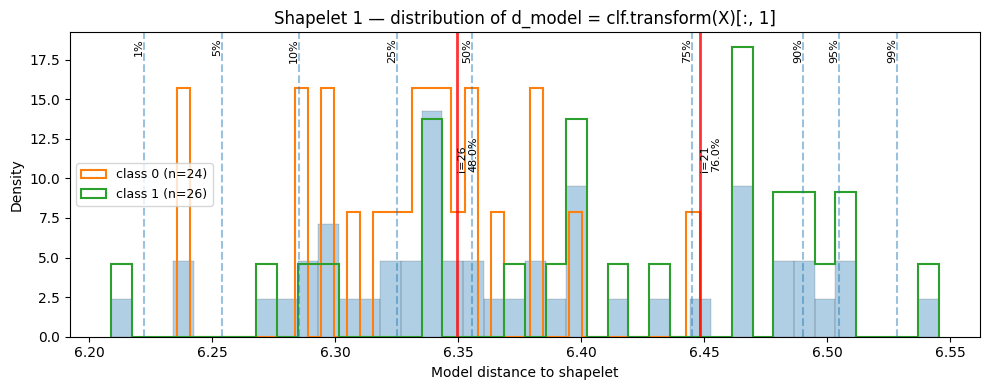

[{'i': 21, 'd_model': 6.448177814483643, 'percentile_rank': 76.0}, {'i': 26, 'd_model': 6.349668502807617, 'percentile_rank': 48.0}]


In [ ]:
with device_scope(keras_device):
    # highlight the exact series you plotted in your overlay function:
    chosen = [21, 26]  # for example
    shapelet_idx = 1
    out = plot_shapelet_distance_distribution(
        clf,
        X_train,
        y_train,
        shapelet_idx=shapelet_idx,
        highlight_indices=chosen,
        savepath=viz_dir / f"shapelet_distance_distribution_shp_idx_{shapelet_idx}.png",
    )
    print(out["highlights"])

In [52]:
# CELL 6e
def plot_in_model_raw_space(
    clf,
    X,
    y=None,
    i=0,  # time series index
    shapelet_idx=0,
    show_zoom=True,
):
    """
    Visualize (time series, shapelet) in the exact raw space used by the model:
      - no shapelet rescaling
      - location = clf.locate(X)
      - overlay raw shapelet on raw preprocessed series
    """
    ts = np.asarray(X[i]).ravel()
    shp_raw = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp_raw)

    # model-best start index
    pos = int(np.asarray(clf.locate(X))[i, shapelet_idx])
    pos = max(0, min(pos, len(ts) - L))

    # model distance feature (scalar)
    d_model = float(np.asarray(clf.transform(X))[i, shapelet_idx])

    # figure
    if show_zoom:
        fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharex=False)
        ax0, ax1 = axes
    else:
        fig, ax0 = plt.subplots(1, 1, figsize=(11, 3.5))
        ax1 = None

    title = f"Raw model space overlay: i={i}, shapelet={shapelet_idx}, d_model={d_model:.4g}, pos={pos}"
    if y is not None:
        title += f", y={y[i]}"
    ax0.set_title(title)

    # full series + overlay
    ax0.plot(ts, linewidth=1.2)
    ax0.axvline(pos, linestyle="--", alpha=0.4)
    ax0.plot(np.arange(pos, pos + L), shp_raw, linewidth=2.0)
    ax0.set_xlim(0, len(ts) - 1)
    ax0.set_xlabel("time")
    ax0.set_ylabel("value")

    # zoom on matched window
    if show_zoom:
        seg = ts[pos : pos + L]
        ax1.plot(np.arange(L), seg, linewidth=1.5, label="segment (ts[pos:pos+L])")
        ax1.plot(np.arange(L), shp_raw, linewidth=2.0, label="raw shapelet")
        ax1.set_title("Zoom: matched window vs raw shapelet (same raw space)")
        ax1.set_xlabel("within-window time")
        ax1.set_ylabel("value")
        ax1.legend()

    plt.tight_layout()
    plt.show()

    return {"pos": pos, "d_model": d_model}

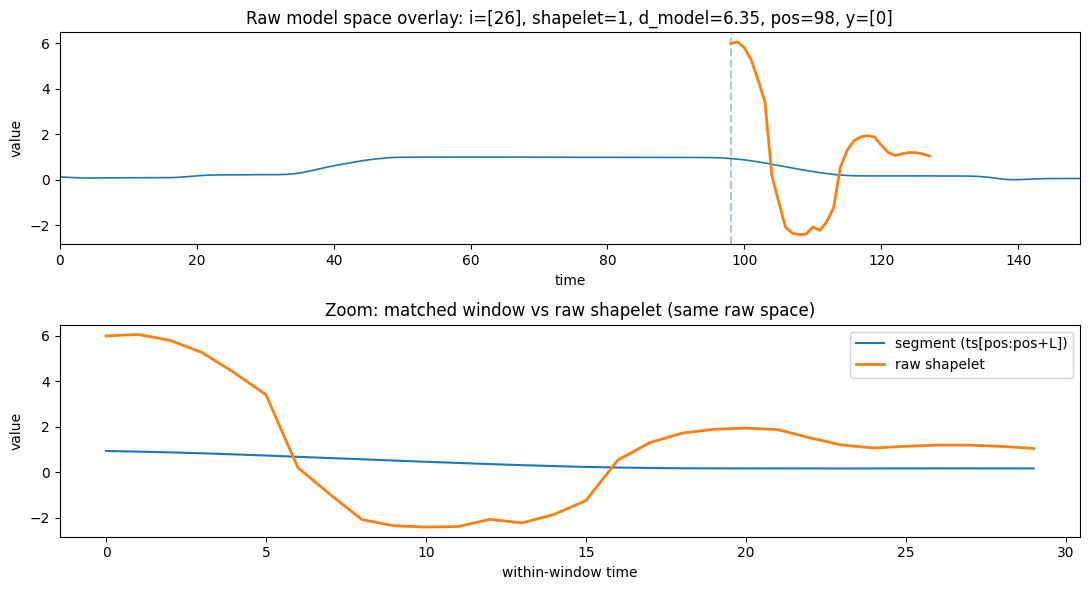

In [53]:
with device_scope(keras_device):
    # pick one of your "chosen" indices
    plot_in_model_raw_space(
        clf, X_train, y_train, i=[26], shapelet_idx=1, show_zoom=True
    )

In [54]:
# CELL 7 — Robustness helpers + robustness runs


def circular_shift(X, rng, max_shift=None):
    Xs = X.copy()
    T = X.shape[1]
    if max_shift is None:
        max_shift = T - 1
    for i in range(X.shape[0]):
        k = int(rng.integers(low=0, high=max_shift + 1))
        Xs[i, :, 0] = np.roll(Xs[i, :, 0], shift=k)
    return Xs


def add_gaussian_noise(X, rng, sigma_rel=0.1):
    Xn = X.copy()
    sigma = sigma_rel * float(X.std())
    Xn += rng.normal(0.0, sigma, size=X.shape).astype(X.dtype)
    return Xn


def robustness_curve(
    model_predict_fn, X_test, y_test, transforms, title, savepath=None
):
    rows = []
    for name, Xmod in transforms:
        pred = model_predict_fn(Xmod)
        rows.append(
            {
                "condition": name,
                "acc": float(accuracy_score(y_test, pred)),
                "bal_acc": float(balanced_accuracy_score(y_test, pred)),
                "f1_macro": float(f1_score(y_test, pred, average="macro")),
            }
        )
    df = pd.DataFrame(rows)

    fig = plt.figure(figsize=(7, 3.5))
    plt.plot(df["condition"], df["acc"], marker="o", label="accuracy")
    plt.plot(df["condition"], df["bal_acc"], marker="o", label="balanced acc")
    plt.ylim(0.0, 1.01)
    plt.xticks(rotation=25, ha="right")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

    return df

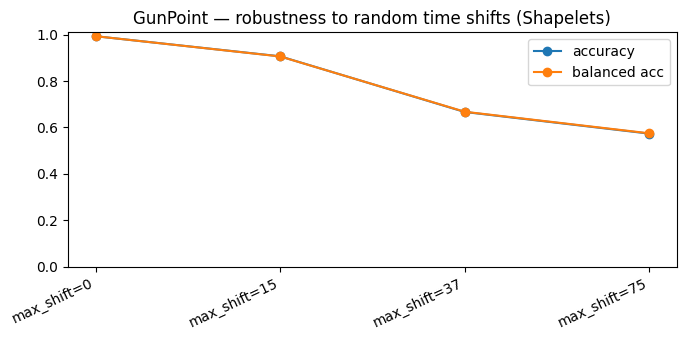

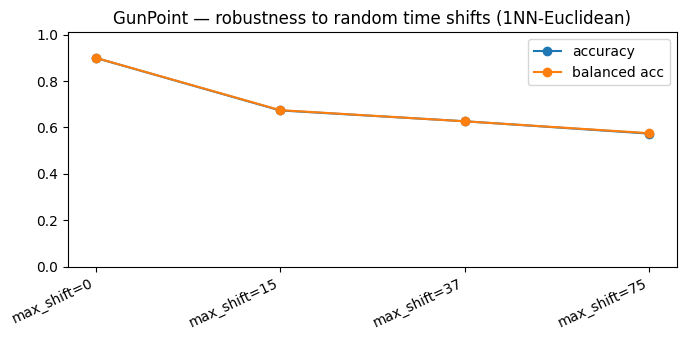

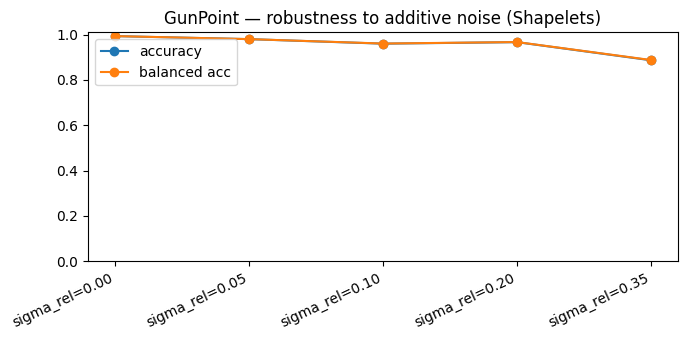

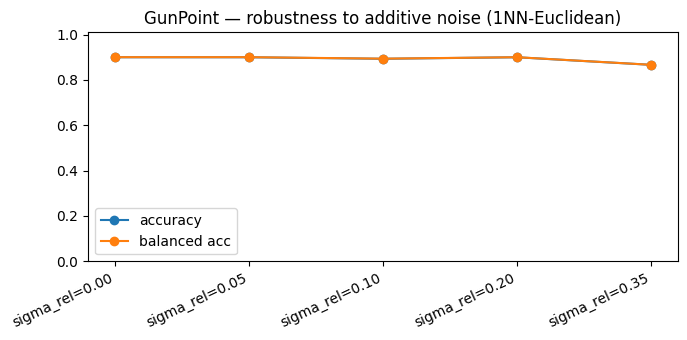

Saved robustness CSVs.


In [55]:
# CELL 7b — Use robustness helpers immediately (Plotting 4)
with device_scope(keras_device):
    # (A) Random circular shifts
    shifts = [
        0,
        int(0.1 * meta["ts_len"]),
        int(0.25 * meta["ts_len"]),
        int(0.5 * meta["ts_len"]),
    ]
    shift_transforms = []
    rng = np.random.default_rng(0)
    for s in shifts:
        Xs = X_test if s == 0 else circular_shift(X_test, rng=rng, max_shift=s)
        shift_transforms.append((f"max_shift={s}", Xs))

    df_shift_shapelets = robustness_curve(
        model_predict_fn=lambda X: clf.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=shift_transforms,
        title=f"{meta['dataset']} — robustness to random time shifts (Shapelets)",
        savepath=viz_dir / f"{meta['dataset']}_robust_shift_shapelets.png",
    )

    df_shift_euc = robustness_curve(
        model_predict_fn=lambda X: knn_euc.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=shift_transforms,
        title=f"{meta['dataset']} — robustness to random time shifts (1NN-Euclidean)",
        savepath=out_dir / f"{meta['dataset']}_robust_shift_1nn_euc.png",
    )

    # (B) Additive noise
    sigmas = [0.0, 0.05, 0.10, 0.20, 0.35]
    noise_transforms = []
    rng = np.random.default_rng(0)
    for s in sigmas:
        Xn = X_test if s == 0 else add_gaussian_noise(X_test, rng=rng, sigma_rel=s)
        noise_transforms.append((f"sigma_rel={s:.2f}", Xn))

    df_noise_shapelets = robustness_curve(
        model_predict_fn=lambda X: clf.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=noise_transforms,
        title=f"{meta['dataset']} — robustness to additive noise (Shapelets)",
        savepath=viz_dir / f"{meta['dataset']}_robust_noise_shapelets.png",
    )

    df_noise_euc = robustness_curve(
        model_predict_fn=lambda X: knn_euc.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=noise_transforms,
        title=f"{meta['dataset']} — robustness to additive noise (1NN-Euclidean)",
        savepath=out_dir / f"{meta['dataset']}_robust_noise_1nn_dtw.png",
    )

    df_shift_shapelets.to_csv(
        viz_dir / f"{meta['dataset']}_robust_shift_shapelets.csv", index=False
    )
    df_shift_euc.to_csv(
        out_dir / f"{meta['dataset']}_robust_shift_1nn_euc.csv", index=False
    )
    df_noise_shapelets.to_csv(
        viz_dir / f"{meta['dataset']}_robust_noise_shapelets.csv", index=False
    )
    df_noise_euc.to_csv(
        out_dir / f"{meta['dataset']}_robust_noise_1nn_dtw.csv", index=False
    )

    print("Saved robustness CSVs.")